# **Employer Project: MSF Operational Centre Brussels**

#### ✅ **Aim of the analysis**: 
Assess whether MS are successful in delivering impact and outcomes for local populations and determine the drivers of project success. 'Success' of MSF projects will be determined through the following KPIs from MSF's Operational Quality Framework:
1. Relevance - to what extent did projects meet local needs?
2. Do No Harm - to what extent did projects mitigate risks for the local environment and population?

#### 📊 **Analytical Questions:**

1. Which countries and projects successfully deliver impact and better outcomes for local populations?
2. What does the qualitative feedback tell us about how MSF projects incorporate local needs and mitigate risk for local populations?
3. How does the perspective on impact and outcomes differ by staff positions?
4. What are the strongest predictors of better impact and outcomes?

We will do this through a combination of descriptive, diagnostic and predictive analysis techniques. 

#### 📑 **Contents:**
1. Loading packages and setting functions
2. Loading data and data cleaning
3. Exploratory data analysis
4. Descriptive analysis
5. Predictive analysis
6. Summary and conclusions

## **Section 1️⃣: Loading packages and setting functions**

### 1.1 Loading packages

In [2]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Predictive analysis libraries
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Always show all columns in head()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 

### 1.2 Set functions

In [3]:
# Function to do basic data exploration for new datasets, as a function in case new data sets are used
def basic_explore(df):
    """
    Basic data exploration of a new dataset using usual functions. 

    Parameters:
    - df (pd.DataFrame): input dataset.

    Returns: 
    - dict containing the shape, dtypes, columns, and head of the dataframe.
    """
    print("Shape:", df.shape, "\n", "\n")
    print("Data types:\n", df.dtypes, "\n", "\n")
    print("Columns:\n", df.columns.tolist(), "\n", "\n")
    print("Head:\n", df.head(), "\n", "\n")
    print("Null Counts\n", df.isnull().sum())

In [4]:
# Function to create a histogram and describe() numerical variables
def variable_explore(df, col):
    """
    Basic exploration of each column with numerical values. 

    Parameters:
    - df (pd.DataFrame): input dataset.
    - col (str): column to explore

    Returns: 
    - histogram of variable
    - basic descriptive statistics
    """
    print(df[col].describe())
    plt.hist(df[col], edgecolor="white")

In [5]:
# Function to define a dataset, group by column(s), then count total number and % per category
def group_total_percent(df, group_cols):
    """
    Groups the df by one or more columns, counts rows per category,
    sorts descending, and calculates percentage of total.

    Parameters:
    - df (pd.DataFrame): input dataset
    - group_cols (str or list): column(s) to group by

    Returns:
    - pd.DataFrame: grouped, sorted DataFrame with 'count' and 'percentage' columns
    """
    if isinstance(group_cols, str):
        group_cols = [group_cols]

    # Group by the columns and count rows
    grouped = df.groupby(group_cols).size().reset_index(name='count')

    # Calculate percentage per group
    total = grouped['count'].sum()
    grouped['percentage'] = (grouped['count'] / total) * 100

    # Sort descending by count
    grouped = grouped.sort_values('count', ascending=False).reset_index(drop=True)

    return grouped

In [6]:
# Create function to see spread of quantitaive question answers by categorical variable
def question_spread(df, category, question, column_order=None):
    """
    Creates a percentage table of `column_var` grouped by `index_var`.

    Parameters:
    - df (pd.DataFrame): input DataFrame
    - index_var (str): column to use as rows (group by)
    - column_var (str): column to pivot (values to calculate percentages for)
    - column_order (list, optional): desired order of columns in output

    Returns:
    - pd.DataFrame: rows=index_var, columns=column_var, values as percentages
    """
    # Drop missing values in relevant columns
    tmp = df.dropna(subset=[category, question])

    # Pivot counts
    pivot = tmp.pivot_table(
        index=category,
        columns=question,
        aggfunc='size',
        fill_value=0
    )

    # Convert to percentages row-wise
    pivot = pivot.div(pivot.sum(axis=1), axis=0) * 100

    # Reorder columns if specified
    if column_order is not None:
        pivot = pivot.reindex(columns=column_order, fill_value=0)

    return pivot

## **Section 2️⃣: Loading and cleaning data**

### 2.1 Load data

In [7]:
# Load the raw dataset 
raw_data = pd.read_csv('raw_data.csv') 

In [8]:
# Use function to explore data 
basic_explore(raw_data)

Shape: (5000, 58) 
 

Data types:
 CompletedDate_EndofAssignment             object
Coordinator_EndofAssignment               object
DevelopmentAdvisor_EndofAssignment        object
Email_EndofAssignment                     object
HR_Coordinator_EndofAssignment            object
ID_EndofAssignment                       float64
LineManager_EndofAssignment               object
NameSurname_EndofAssignment               object
OtherUsers_EndofAssignment                object
PoolManager_EndofAssignment               object
Position_EndofAssignment                  object
PositionCode(Hidden)_EndofAssignment      object
Project_EndofAssignment                   object
ProjectCode_EndofAssignment               object
ProjectCountry_EndofAssignment            object
ProjectCountryCode_EndofAssignment        object
RequestDebriefingWith_EndofAssignment     object
StartedDate_EndofAssignment               object
Status_EndofAssignment                    object
Title_EndofAssignment             

In [9]:
raw_data.tail()

,CompletedDate_EndofAssignment,Coordinator_EndofAssignment,DevelopmentAdvisor_EndofAssignment,Email_EndofAssignment,HR_Coordinator_EndofAssignment,ID_EndofAssignment,LineManager_EndofAssignment,NameSurname_EndofAssignment,OtherUsers_EndofAssignment,PoolManager_EndofAssignment,Position_EndofAssignment,PositionCode(Hidden)_EndofAssignment,Project_EndofAssignment,ProjectCode_EndofAssignment,ProjectCountry_EndofAssignment,ProjectCountryCode_EndofAssignment,RequestDebriefingWith_EndofAssignment,StartedDate_EndofAssignment,Status_EndofAssignment,Title_EndofAssignment,Answer_Feedbacks,EndOfAssignmentFK_Feedbacks,ID_Feedbacks,Quantitative_Feedbacks,QuestionID_Feedbacks,Scale_Feedbacks,Active_PartnerSections,ID_PartnerSections,Title_PartnerSections,Active_Positions,Email_Positions,ID_Positions,Partners FK_Positions,Position Code_Positions,Project Countries FK_Positions,Projects FK_Positions,Title_Positions,Active_ProjectCountries,Code_ProjectCountries,ID_ProjectCountries,Title_ProjectCountries,Active_Projects,ID_Projects,Project Country FK_Projects,ProjectCode_Projects,Title_Projects,Quality Criteria_Questions,Question_Questions,Question ID_Questions,Scoring System_Questions,Type_Questions,Email _Subscriptions,ID _Subscriptions,PartnersFK _Subscriptions,Positions FK,ProjectCountriesFK _Subscriptions,ProjectsFK _Subscriptions,Title _Subscriptions
4995,23 September 2025,Sara Umar,Kofi Qureshi,timothywhite@example.com,Michelle Fischer,183.0,Nadia Jean,Timothy White,NaN,Elena Chen,POS-00183,POS-00183,Project None,HTI-PRJ-2,Haiti,HTI,HR,18 September 2025,In Progress,Mr,Regular check-ins helped during surge weeks.,183.0,4008.0,False,4.0,NaN,True,1.0,OCB,True,user183@example.org,183.0,1.0,POS-00183,5.0,10.0,Midwife,True,HTI,5.0,Haiti,True,10.0,5.0,HTI-PRJ-2,Project 2 in Haiti,Effectiveness,Did the project achieve its expected results? ...,4.0,Free Text,Open Question – Qualitative,user183@example.org,183.0,1.0,183.0,5.0,10.0,Position Alerts - POS-00183
4996,23 September 2025,Sara Umar,Kofi Qureshi,timothywhite@example.com,Michelle Fischer,183.0,Nadia Jean,Timothy White,NaN,Elena Chen,POS-00183,POS-00183,Project None,HTI-PRJ-2,Haiti,HTI,HR,18 September 2025,In Progress,Mr,Regular check-ins helped during surge weeks.,183.0,4014.0,False,10.0,NaN,True,1.0,OCB,True,user183@example.org,183.0,1.0,POS-00183,5.0,10.0,Midwife,True,HTI,5.0,Haiti,True,10.0,5.0,HTI-PRJ-2,Project 2 in Haiti,Coherent with MSF Values,How well did the team understand and promote M...,10.0,Free Text,Open Question – Qualitative,user183@example.org,183.0,1.0,183.0,5.0,10.0,Position Alerts - POS-00183
4997,23 September 2025,Sara Umar,Kofi Qureshi,timothywhite@example.com,Michelle Fischer,183.0,Nadia Jean,Timothy White,NaN,Elena Chen,POS-00183,POS-00183,Project None,HTI-PRJ-2,Haiti,HTI,HR,18 September 2025,In Progress,Mr,Shared SOPs improved handovers between rotations.,183.0,4024.0,False,20.0,NaN,True,1.0,OCB,True,user183@example.org,183.0,1.0,POS-00183,5.0,10.0,Midwife,True,HTI,5.0,Haiti,True,10.0,5.0,HTI-PRJ-2,Project 2 in Haiti,Learning from Experience,How well were experiences and best practices d...,20.0,1: Very Poor| 2: Poor| 3: Fair| 4: Good| 5: Ex...,Quantitative,user183@example.org,183.0,1.0,183.0,5.0,10.0,Position Alerts - POS-00183
4998,23 September 2025,Sara Umar,Kofi Qureshi,timothywhite@example.com,Michelle Fischer,183.0,Nadia Jean,Timothy White,NaN,Elena Chen,POS-00183,POS-00183,Project None,HTI-PRJ-2,Haiti,HTI,HR,18 September 2025,In Progress,Mr,Workload,183.0,4019.0,False,15.0,Workload| Safety and Security| Living Conditio...,True,1.0,OCB,True,user183@example.org,183.0,1.0,POS-00183,5.0,10.0,Midwife,True,HTI,5.0,Haiti,True,10.0,5.0,HTI-PRJ-2,Project 2 in Haiti,Staff is Supported and Cared For,Which of the following areas were most problem...,15.0,Workload| Safety and Security| Living Conditio...,Multiple Choices,user183@example.org,183.0,1.0,183.0,5.0,10.0,Position Alerts - POS-00183
4999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [10]:
# Create a copy dataset to manipulate
msf = raw_data.copy()

### 2.2 Initial data clean

In [11]:
# Drop null row
msf = msf.dropna(how='all')

In [12]:
# Check whether any columns are duplicates (especially the FKs)
msf.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

       ID_EndofAssignment  EndOfAssignmentFK_Feedbacks  ID_Feedbacks  \
count         4999.000000                  4999.000000   4999.000000   
mean           114.114023                   114.114023   2500.000000   
std             65.601461                    65.601461   1443.231328   
min              1.000000                     1.000000      1.000000   
25%             57.000000                    57.000000   1250.500000   
50%            114.000000                   114.000000   2500.000000   
75%            171.000000                   171.000000   3749.500000   
max            228.000000                   228.000000   4999.000000   

       QuestionID_Feedbacks  ID_PartnerSections  ID_Positions  \
count           4999.000000              4999.0   4999.000000   
mean              11.491498                 1.0    114.114023   
std                6.347598                 0.0     65.601461   
min                1.000000                 1.0      1.000000   
25%                6.00000

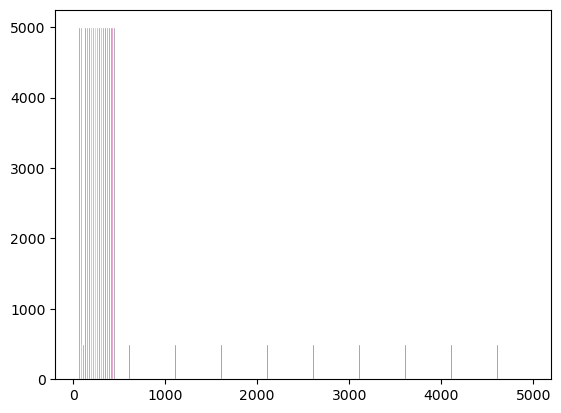

In [13]:
# Explore numerical columns 
num_cols = msf.select_dtypes(include=['number']).columns.tolist()

variable_explore(msf, num_cols)

In [14]:
# Explore non-numerical columns
non_num_cols = msf.select_dtypes(exclude=['number']).columns.tolist()

for col in non_num_cols: 
    print(group_total_percent(msf, col))
    print("\n")

    CompletedDate_EndofAssignment  count  percentage
0                   09 April 2025     88    1.760352
1                   02 March 2025     66    1.320264
2                     23 May 2024     66    1.320264
3               10 September 2025     66    1.320264
4                13 November 2024     66    1.320264
..                            ...    ...         ...
189              10 November 2024     22    0.440088
190                11 August 2024     22    0.440088
191                11 August 2025     22    0.440088
192              11 December 2024     22    0.440088
193                 15 April 2024     22    0.440088

[194 rows x 3 columns]


  Coordinator_EndofAssignment  count  percentage
0                George Novak   1012   20.244049
1                Priya Zuberi   1012   20.244049
2                   Sara Umar    995   19.903981
3                    Carl Lee    990   19.803961
4                 Chloe Gomes    990   19.803961


  DevelopmentAdvisor_EndofAssignment  coun

In [15]:
# Drop columns which aren't useful
msf = msf.drop([ # Not useful
                     'Email_EndofAssignment', 
                     'Email_Positions',
                     'Email _Subscriptions',
                     'Question_Questions',
    
                      # Not useful once restructure data
                     'Type_Questions', 
                     'Scoring System_Questions', 
                     'Quantitative_Feedbacks', 
                     'Scale_Feedbacks', 
    
                      # All same value
                     'Partners FK_Positions', 
                     'ID_PartnerSections',
                     'PartnersFK _Subscriptions',
                     'HR_Coordinator_EndofAssignment', # Note: this is all the same for this data - would it be for real data?
                     'Project_EndofAssignment', # Note: this is all the same for this data - would it be for real data?
                     'Active_PartnerSections', # As above
                     'Title_PartnerSections', # As above
                     'Active_Positions', # As above
    
                      # Duplicative column
                     'PositionCode(Hidden)_EndofAssignment',
                     'Position Code_Positions',
                     'ProjectCountryCode_EndofAssignment',
                     'Code_ProjectCountries',
                     'Title_ProjectCountries',
                     'Active_ProjectCountries', 
                     'Active_Projects',
                     'Question ID_Questions'
                    ],
                   axis=1)

In [16]:
# Check column names
msf.columns.tolist()

['CompletedDate_EndofAssignment',
 'Coordinator_EndofAssignment',
 'DevelopmentAdvisor_EndofAssignment',
 'ID_EndofAssignment',
 'LineManager_EndofAssignment',
 'NameSurname_EndofAssignment',
 'OtherUsers_EndofAssignment',
 'PoolManager_EndofAssignment',
 'Position_EndofAssignment',
 'ProjectCode_EndofAssignment',
 'ProjectCountry_EndofAssignment',
 'RequestDebriefingWith_EndofAssignment',
 'StartedDate_EndofAssignment',
 'Status_EndofAssignment',
 'Title_EndofAssignment',
 'Answer_Feedbacks',
 'EndOfAssignmentFK_Feedbacks',
 'ID_Feedbacks',
 'QuestionID_Feedbacks',
 'ID_Positions',
 'Project Countries FK_Positions',
 'Projects FK_Positions',
 'Title_Positions',
 'ID_ProjectCountries',
 'ID_Projects',
 'Project Country FK_Projects',
 'ProjectCode_Projects',
 'Title_Projects',
 'Quality Criteria_Questions',
 'ID _Subscriptions',
 'Positions FK',
 'ProjectCountriesFK _Subscriptions',
 'ProjectsFK _Subscriptions',
 'Title _Subscriptions']

In [17]:
# Rename columns 
msf = msf.rename(columns = {
    'CompletedDate_EndofAssignment' : 'end_date',
    'Coordinator_EndofAssignment' : 'coordinator',
    'DevelopmentAdvisor_EndofAssignment' : 'dev_advisor', 
    'ID_EndofAssignment' : 'id', 
    'LineManager_EndofAssignment' : 'line_manager',
    'NameSurname_EndofAssignment' : 'employee_name',
    'OtherUsers_EndofAssignment' : 'other_users',
    'PoolManager_EndofAssignment' : 'pool_manager',
    'Position_EndofAssignment' : 'position_name',
    'ProjectCode_EndofAssignment' : 'project_code',
    'ProjectCountry_EndofAssignment' : 'project_country',
    'RequestDebriefingWith_EndofAssignment' : 'debrief_requested',
    'StartedDate_EndofAssignment' : 'start_date',
    'Status_EndofAssignment' : 'status',
    'Title_EndofAssignment' : 'employees_personal_title',
    'Answer_Feedbacks' : 'survey_answer',
    'ID_Feedbacks' : 'feedback_id',
    'QuestionID_Feedbacks' : 'question_id',
    'Active_PartnerSections' : 'active_partner',
    'ID_PartnerSections' : 'partner_id',
    'Title_PartnerSections' : 'partner_name',
    'Active_Positions' : 'position_active',
    'ID_Positions' : 'position_id',
    'Project Countries FK_Positions' : 'country_code_fk',
    'Projects FK_Positions' : 'projects_fk_code',
    'Title_Positions' : 'position_title',    
    'ID_ProjectCountries' : 'id_project_countries',
    'ID_Projects' : 'id_projects',
    'Project Country FK_Projects' : 'project_country_fk_projects',
    'ProjectCode_Projects' : 'project_code_projects',
    'Title_Projects' : 'title_projects',
    'Quality Criteria_Questions' : 'kpi',
    'ID _Subscriptions' : 'id_subscriptions',
    'Positions FK' : 'positions_fk',
    'ProjectCountriesFK _Subscriptions' : 'project_countries_fk_subscriptions',
    'ProjectsFK _Subscriptions' : 'projects_fk_subscriptions',
    'Title _Subscriptions' : 'title_subscriptions',
    'EndOfAssignmentFK_Feedbacks' : 'feedback_fk'
})

In [18]:
# Investigate columns with high null counts
high_null_cols = msf.columns[msf.isnull().any()].tolist()

for col in high_null_cols: 
    print(group_total_percent(msf, col))
    print('\n')

        other_users  count  percentage
0          Uma Chen     66    2.083333
1     Waleed Rahman     44    1.388889
2       Ben Tadesse     44    1.388889
3    Valerie Rahman     44    1.388889
4      Elena Yakubu     44    1.388889
..              ...    ...         ...
124       Hassan Xu     22    0.694444
125     Hassan Umar     22    0.694444
126   Hassan Mensah     22    0.694444
127     Hassan Bako     22    0.694444
128      Zoe Zuberi     22    0.694444

[129 rows x 3 columns]


  debrief_requested  count  percentage
0      Line Manager   1413   37.730307
1              Both   1232   32.897196
2                HR   1100   29.372497


                                         survey_answer  count  percentage
0                                                    3    848   17.384174
1                                                    4    634   12.997130
2         Regular check-ins helped during surge weeks.    418    8.569086
3    Accommodation improved after early feedback cy.

### 2.3 Data reshaping

Reshape the data so there is one entry for each person (employee_name), and each question is a new column.

In [19]:
# Create column with new question column names

# Change question_id to integer
msf['question_id'] = msf['question_id'].astype(int)

# Combine question_id and the kpi label
msf['question'] = msf['question_id'].astype(str) + '_' + msf['kpi']

In [20]:
# Pivot to wide
wide_msf = msf.pivot_table(
    index=[
         'id',
         'employees_personal_title',
         'employee_name',
         'start_date',
         'end_date',
    ],
    columns='question',
    values='survey_answer',
    aggfunc='first'
).reset_index()

In [21]:
# Check 
wide_msf.head()

question,id,employees_personal_title,employee_name,start_date,end_date,10_Coherent with MSF Values,11_Population Centeredness,12_Population Centeredness,13_Staff is Supported and Cared For,14_Staff is Supported and Cared For,15_Staff is Supported and Cared For,16_Staff is Supported and Cared For,17_Resources are Used Responsibly,18_Resources are Used Responsibly,19_Learning from Experience,1_Relevance,20_Learning from Experience,21_Agile and Clear Decisions,22_Agile and Clear Decisions,2_Relevance,3_Effectiveness,4_Effectiveness,5_Do No Harm,6_Do No Harm,7_Integrated in Environment,8_Integrated in Environment,9_Coherent with MSF Values
0,1.0,Mr,Jay Freeman,01 April 2025,04 April 2025,Psycho-social support existed but was hard to ...,3,Women’s groups informed clinic scheduling.,2,Regular check-ins helped during surge weeks.,Psychological Support| Safety and Security,NaN,3,Budget Management,After-action reviews captured outreach lessons.,3,After-action reviews captured outreach lessons.,4,Decision logs increased transparency for the t...,NaN,2,Accommodation improved after early feedback cy...,1,Regular check-ins helped during surge weeks.,5,Local partner coordination reduced duplication.,4
1,2.0,Ms/Mrs,Harper Porter,16 April 2024,21 April 2024,Regular check-ins helped during surge weeks.,2,Feedback mechanisms improved complaint handling.,2,NaN,Psychological Support,Accommodation improved after early feedback cy...,4,Other (please specify),NaN,4,After-action reviews captured outreach lessons.,3,Daily briefs clarified ownership and timelines.,Women’s groups informed clinic scheduling.,3,Psycho-social support existed but was hard to ...,4,Psycho-social support existed but was hard to ...,4,Local partner coordination reduced duplication.,4
2,3.0,Ms/Mrs,Sarahann Boyd,23 August 2025,23 August 2025,Regular check-ins helped during surge weeks.,4,Women’s groups informed clinic scheduling.,4,Regular check-ins helped during surge weeks.,Living Conditions| Psychological Support| Work...,Accommodation improved after early feedback cy...,4,Fraud and Corruption| Resource Allocation,Shared SOPs improved handovers between rotations.,3,Case reviews were documented and shared in the...,4,Daily briefs clarified ownership and timelines.,Feedback mechanisms improved complaint handling.,4,Psycho-social support existed but was hard to ...,2,Psycho-social support existed but was hard to ...,3,Context analysis informed SOP adaptation.,5
3,4.0,Ms/Mrs,Alexandra Barnes,31 March 2024,03 April 2024,Regular check-ins helped during surge weeks.,3,Women’s groups informed clinic scheduling.,3,Regular check-ins helped during surge weeks.,Others (please specify),Accommodation improved after early feedback cy...,4,Budget Management,After-action reviews captured outreach lessons.,4,Shared SOPs improved handovers between rotations.,4,NaN,Women’s groups informed clinic scheduling.,4,NaN,4,Psycho-social support existed but was hard to ...,3,Local partner coordination reduced duplication.,3
4,5.0,Ms/Mrs,Daisy Johnson,07 January 2024,10 January 2024,NaN,3,Women’s groups informed clinic scheduling.,3,Regular check-ins helped during surge weeks.,Communication with Management| Training and De...,Accommodation improved after early feedback cy...,2,Fraud and Corruption| Resource Waste,NaN,4,Case reviews were documented and shared in the...,1,Approval thresholds were unclear during escala...,Feedback mechanisms improved complaint handling.,3,Regular check-ins helped during surge weeks.,2,Accommodation improved after early feedback cy...,4,Joint supervisions with MoH improved referrals.,1


In [22]:
# Isolate descriptive columns to merge back with wide_msf
descriptive_cols = ['id', 'coordinator', 'dev_advisor', 'line_manager', 'other_users',
 'pool_manager', 'position_name', 'project_code', 'project_country', 'debrief_requested', 'status',
 'feedback_fk', 'feedback_id', 'position_id', 'country_code_fk',
 'projects_fk_code', 'position_title', 'id_project_countries', 'id_projects', 'project_country_fk_projects',
 'project_code_projects', 'title_projects', 'id_subscriptions', 'positions_fk',
 'project_countries_fk_subscriptions', 'projects_fk_subscriptions', 'title_subscriptions',
]

# Remove duplicates
descriptive_df = msf[descriptive_cols].drop_duplicates(subset=['id'])

# Merge back with main dataset
final_msf = wide_msf.merge(descriptive_df, on='id', how='left')

In [23]:
# Check
final_msf.head()

,id,employees_personal_title,employee_name,start_date,end_date,10_Coherent with MSF Values,11_Population Centeredness,12_Population Centeredness,13_Staff is Supported and Cared For,14_Staff is Supported and Cared For,15_Staff is Supported and Cared For,16_Staff is Supported and Cared For,17_Resources are Used Responsibly,18_Resources are Used Responsibly,19_Learning from Experience,1_Relevance,20_Learning from Experience,21_Agile and Clear Decisions,22_Agile and Clear Decisions,2_Relevance,3_Effectiveness,4_Effectiveness,5_Do No Harm,6_Do No Harm,7_Integrated in Environment,8_Integrated in Environment,9_Coherent with MSF Values,coordinator,dev_advisor,line_manager,other_users,pool_manager,position_name,project_code,project_country,debrief_requested,status,feedback_fk,feedback_id,position_id,country_code_fk,projects_fk_code,position_title,id_project_countries,id_projects,project_country_fk_projects,project_code_projects,title_projects,id_subscriptions,positions_fk,project_countries_fk_subscriptions,projects_fk_subscriptions,title_subscriptions
0,1.0,Mr,Jay Freeman,01 April 2025,04 April 2025,Psycho-social support existed but was hard to ...,3,Women’s groups informed clinic scheduling.,2,Regular check-ins helped during surge weeks.,Psychological Support| Safety and Security,NaN,3,Budget Management,After-action reviews captured outreach lessons.,3,After-action reviews captured outreach lessons.,4,Decision logs increased transparency for the t...,NaN,2,Accommodation improved after early feedback cy...,1,Regular check-ins helped during surge weeks.,5,Local partner coordination reduced duplication.,4,George Novak,Yara El-Masri,Nadia Jean,NaN,Tariq Ionescu,POS-00001,AFG-PRJ-1,Afghanistan,Line Manager,Completed,1.0,2.0,1.0,6.0,11.0,Field Coordinator,6.0,11.0,6.0,AFG-PRJ-1,Project 1 in Afghanistan,1.0,1.0,6.0,11.0,Position Alerts - POS-00001
1,2.0,Ms/Mrs,Harper Porter,16 April 2024,21 April 2024,Regular check-ins helped during surge weeks.,2,Feedback mechanisms improved complaint handling.,2,NaN,Psychological Support,Accommodation improved after early feedback cy...,4,Other (please specify),NaN,4,After-action reviews captured outreach lessons.,3,Daily briefs clarified ownership and timelines.,Women’s groups informed clinic scheduling.,3,Psycho-social support existed but was hard to ...,4,Psycho-social support existed but was hard to ...,4,Local partner coordination reduced duplication.,4,Priya Zuberi,Lena Diaz,Nadia Jean,Ivy Bako,Elena Chen,POS-00002,DRC-PRJ-2,Democratic Republic of the Congo,NaN,Completed,2.0,36.0,2.0,1.0,2.0,Midwife,1.0,2.0,1.0,DRC-PRJ-2,Project 2 in Democratic Republic of the Congo,2.0,2.0,1.0,2.0,Position Alerts - POS-00002
2,3.0,Ms/Mrs,Sarahann Boyd,23 August 2025,23 August 2025,Regular check-ins helped during surge weeks.,4,Women’s groups informed clinic scheduling.,4,Regular check-ins helped during surge weeks.,Living Conditions| Psychological Support| Work...,Accommodation improved after early feedback cy...,4,Fraud and Corruption| Resource Allocation,Shared SOPs improved handovers between rotations.,3,Case reviews were documented and shared in the...,4,Daily briefs clarified ownership and timelines.,Feedback mechanisms improved complaint handling.,4,Psycho-social support existed but was hard to ...,2,Psycho-social support existed but was hard to ...,3,Context analysis informed SOP adaptation.,5,Sara Umar,Kofi Qureshi,Ben Logan,NaN,Maya Khan,POS-00003,UKR-PRJ-1,Ukraine,HR,Completed,3.0,49.0,3.0,4.0,7.0,Pharmacist,4.0,7.0,4.0,UKR-PRJ-1,Project 1 in Ukraine,3.0,3.0,4.0,7.0,Position Alerts - POS-00003
3,4.0,Ms/Mrs,Alexandra Barnes,31 March 2024,03 April 2024,Regular check-ins helped during surge weeks.,3,Women’s groups informed clinic scheduling.,3,Regular check-ins helped during surge weeks.,Others (please specify),Accommodation improved after early feedback cy...,4,Budget Management,After-action reviews captured outreach lessons.,4,Shared SOPs improved handovers between rotations.,4,NaN,Women’s groups informed c

In [24]:
# Clean column names 
final_msf.columns = [c.strip().lower().replace(' ', '_') for c in final_msf.columns]

final_msf.head()

,id,employees_personal_title,employee_name,start_date,end_date,10_coherent_with_msf_values,11_population_centeredness,12_population_centeredness,13_staff_is_supported_and_cared_for,14_staff_is_supported_and_cared_for,15_staff_is_supported_and_cared_for,16_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,18_resources_are_used_responsibly,19_learning_from_experience,1_relevance,20_learning_from_experience,21_agile_and_clear_decisions,22_agile_and_clear_decisions,2_relevance,3_effectiveness,4_effectiveness,5_do_no_harm,6_do_no_harm,7_integrated_in_environment,8_integrated_in_environment,9_coherent_with_msf_values,coordinator,dev_advisor,line_manager,other_users,pool_manager,position_name,project_code,project_country,debrief_requested,status,feedback_fk,feedback_id,position_id,country_code_fk,projects_fk_code,position_title,id_project_countries,id_projects,project_country_fk_projects,project_code_projects,title_projects,id_subscriptions,positions_fk,project_countries_fk_subscriptions,projects_fk_subscriptions,title_subscriptions
0,1.0,Mr,Jay Freeman,01 April 2025,04 April 2025,Psycho-social support existed but was hard to ...,3,Women’s groups informed clinic scheduling.,2,Regular check-ins helped during surge weeks.,Psychological Support| Safety and Security,NaN,3,Budget Management,After-action reviews captured outreach lessons.,3,After-action reviews captured outreach lessons.,4,Decision logs increased transparency for the t...,NaN,2,Accommodation improved after early feedback cy...,1,Regular check-ins helped during surge weeks.,5,Local partner coordination reduced duplication.,4,George Novak,Yara El-Masri,Nadia Jean,NaN,Tariq Ionescu,POS-00001,AFG-PRJ-1,Afghanistan,Line Manager,Completed,1.0,2.0,1.0,6.0,11.0,Field Coordinator,6.0,11.0,6.0,AFG-PRJ-1,Project 1 in Afghanistan,1.0,1.0,6.0,11.0,Position Alerts - POS-00001
1,2.0,Ms/Mrs,Harper Porter,16 April 2024,21 April 2024,Regular check-ins helped during surge weeks.,2,Feedback mechanisms improved complaint handling.,2,NaN,Psychological Support,Accommodation improved after early feedback cy...,4,Other (please specify),NaN,4,After-action reviews captured outreach lessons.,3,Daily briefs clarified ownership and timelines.,Women’s groups informed clinic scheduling.,3,Psycho-social support existed but was hard to ...,4,Psycho-social support existed but was hard to ...,4,Local partner coordination reduced duplication.,4,Priya Zuberi,Lena Diaz,Nadia Jean,Ivy Bako,Elena Chen,POS-00002,DRC-PRJ-2,Democratic Republic of the Congo,NaN,Completed,2.0,36.0,2.0,1.0,2.0,Midwife,1.0,2.0,1.0,DRC-PRJ-2,Project 2 in Democratic Republic of the Congo,2.0,2.0,1.0,2.0,Position Alerts - POS-00002
2,3.0,Ms/Mrs,Sarahann Boyd,23 August 2025,23 August 2025,Regular check-ins helped during surge weeks.,4,Women’s groups informed clinic scheduling.,4,Regular check-ins helped during surge weeks.,Living Conditions| Psychological Support| Work...,Accommodation improved after early feedback cy...,4,Fraud and Corruption| Resource Allocation,Shared SOPs improved handovers between rotations.,3,Case reviews were documented and shared in the...,4,Daily briefs clarified ownership and timelines.,Feedback mechanisms improved complaint handling.,4,Psycho-social support existed but was hard to ...,2,Psycho-social support existed but was hard to ...,3,Context analysis informed SOP adaptation.,5,Sara Umar,Kofi Qureshi,Ben Logan,NaN,Maya Khan,POS-00003,UKR-PRJ-1,Ukraine,HR,Completed,3.0,49.0,3.0,4.0,7.0,Pharmacist,4.0,7.0,4.0,UKR-PRJ-1,Project 1 in Ukraine,3.0,3.0,4.0,7.0,Position Alerts - POS-00003
3,4.0,Ms/Mrs,Alexandra Barnes,31 March 2024,03 April 2024,Regular check-ins helped during surge weeks.,3,Women’s groups informed clinic scheduling.,3,Regular check-ins helped during surge weeks.,Others (please specify),Accommodation improved after early feedback cy...,4,Budget Management,After-action reviews captured outreach lessons.,4,Shared SOPs improved handovers between rotations.,4,NaN,Women’s groups informed c

In [25]:
# Change the format of columns 

# Change id and question columns to integer (no decimal places)
int_cols = ['id', 
            'feedback_fk', 
            'feedback_id',
            'position_id', 
            'country_code_fk', 
            'projects_fk_code',
            'id_subscriptions', 
            'positions_fk', 
            'project_countries_fk_subscriptions', 
            'projects_fk_subscriptions',
            '1_relevance',
            '3_effectiveness',
            '5_do_no_harm',
            '7_integrated_in_environment',
            '9_coherent_with_msf_values', 
            '11_population_centeredness',
            '13_staff_is_supported_and_cared_for',
            '17_resources_are_used_responsibly',
            '21_agile_and_clear_decisions']

for col in int_cols:
    final_msf[col] = pd.to_numeric(final_msf[col], errors='coerce').astype('Int64')

# Change start and end date to date format
final_msf['start_date'] = pd.to_datetime(final_msf['start_date'], format='%d %B %Y', errors='coerce')
final_msf['end_date'] = pd.to_datetime(final_msf['end_date'], format='%d %B %Y', errors='coerce')

# Check 
final_msf.head()

,id,employees_personal_title,employee_name,start_date,end_date,10_coherent_with_msf_values,11_population_centeredness,12_population_centeredness,13_staff_is_supported_and_cared_for,14_staff_is_supported_and_cared_for,15_staff_is_supported_and_cared_for,16_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,18_resources_are_used_responsibly,19_learning_from_experience,1_relevance,20_learning_from_experience,21_agile_and_clear_decisions,22_agile_and_clear_decisions,2_relevance,3_effectiveness,4_effectiveness,5_do_no_harm,6_do_no_harm,7_integrated_in_environment,8_integrated_in_environment,9_coherent_with_msf_values,coordinator,dev_advisor,line_manager,other_users,pool_manager,position_name,project_code,project_country,debrief_requested,status,feedback_fk,feedback_id,position_id,country_code_fk,projects_fk_code,position_title,id_project_countries,id_projects,project_country_fk_projects,project_code_projects,title_projects,id_subscriptions,positions_fk,project_countries_fk_subscriptions,projects_fk_subscriptions,title_subscriptions
0,1,Mr,Jay Freeman,2025-04-01,2025-04-04,Psycho-social support existed but was hard to ...,3,Women’s groups informed clinic scheduling.,2,Regular check-ins helped during surge weeks.,Psychological Support| Safety and Security,NaN,3,Budget Management,After-action reviews captured outreach lessons.,3,After-action reviews captured outreach lessons.,4,Decision logs increased transparency for the t...,NaN,2,Accommodation improved after early feedback cy...,1,Regular check-ins helped during surge weeks.,5,Local partner coordination reduced duplication.,4,George Novak,Yara El-Masri,Nadia Jean,NaN,Tariq Ionescu,POS-00001,AFG-PRJ-1,Afghanistan,Line Manager,Completed,1,2,1,6,11,Field Coordinator,6.0,11.0,6.0,AFG-PRJ-1,Project 1 in Afghanistan,1,1,6,11,Position Alerts - POS-00001
1,2,Ms/Mrs,Harper Porter,2024-04-16,2024-04-21,Regular check-ins helped during surge weeks.,2,Feedback mechanisms improved complaint handling.,2,NaN,Psychological Support,Accommodation improved after early feedback cy...,4,Other (please specify),NaN,4,After-action reviews captured outreach lessons.,3,Daily briefs clarified ownership and timelines.,Women’s groups informed clinic scheduling.,3,Psycho-social support existed but was hard to ...,4,Psycho-social support existed but was hard to ...,4,Local partner coordination reduced duplication.,4,Priya Zuberi,Lena Diaz,Nadia Jean,Ivy Bako,Elena Chen,POS-00002,DRC-PRJ-2,Democratic Republic of the Congo,NaN,Completed,2,36,2,1,2,Midwife,1.0,2.0,1.0,DRC-PRJ-2,Project 2 in Democratic Republic of the Congo,2,2,1,2,Position Alerts - POS-00002
2,3,Ms/Mrs,Sarahann Boyd,2025-08-23,2025-08-23,Regular check-ins helped during surge weeks.,4,Women’s groups informed clinic scheduling.,4,Regular check-ins helped during surge weeks.,Living Conditions| Psychological Support| Work...,Accommodation improved after early feedback cy...,4,Fraud and Corruption| Resource Allocation,Shared SOPs improved handovers between rotations.,3,Case reviews were documented and shared in the...,4,Daily briefs clarified ownership and timelines.,Feedback mechanisms improved complaint handling.,4,Psycho-social support existed but was hard to ...,2,Psycho-social support existed but was hard to ...,3,Context analysis informed SOP adaptation.,5,Sara Umar,Kofi Qureshi,Ben Logan,NaN,Maya Khan,POS-00003,UKR-PRJ-1,Ukraine,HR,Completed,3,49,3,4,7,Pharmacist,4.0,7.0,4.0,UKR-PRJ-1,Project 1 in Ukraine,3,3,4,7,Position Alerts - POS-00003
3,4,Ms/Mrs,Alexandra Barnes,2024-03-31,2024-04-03,Regular check-ins helped during surge weeks.,3,Women’s groups informed clinic scheduling.,3,Regular check-ins helped during surge weeks.,Others (please specify),Accommodation improved after early feedback cy...,4,Budget Management,After-action reviews captured outreach lessons.,4,Shared SOPs improved handovers between rotations.,4,NaN,Women’s groups informed clinic scheduling.,4,NaN,4,Psycho-social support existed but was hard to ...,3,Local part

In [26]:
# Add the scale descriptions to the dataset
# Define per-question scales 
scales = {
    "1_relevance": {
        1: "Not at all",
        2: "To a small extent",
        3: "To a moderate extent",
        4: "To a large extent",
        5: "Completely",
    },
    "3_effectiveness": {
        1: "Not realistic/achievable",
        2: "Slightly realistic/achievable",
        3: "Moderately realistic/achievable",
        4: "Mostly realistic/achievable",
        5: "Completely realistic/achievable"
    },
    "5_do_no_harm": {
        1: "Not identified/mitigated at all",
        2: "Slightly identified/mitigated",
        3: "Moderately identified/mitigated",
        4: "Mostly identified/mitigated",
        5: "Completely identified/mitigated"
    },
    "7_integrated_in_environment": {
        1: "Not integrated at all",
        2: "Slightly integrated",
        3: "Moderately integrated",
        4: "Mostly integrated",
        5: "Completely integrated"
    },
    "9_coherent_with_msf_values": {
        1: "Not at all",
        2: "Slightly",
        3: "Moderately",
        4: "Mostly",
        5: "Completely"
    },
    "11_population_centeredness": {
        1: "Not assessed/addressed at all",
        2: "Slightly assessed/addressed",
        3: "Moderately assessed/addressed",
        4: "Mostly assessed/addressed",
        5: "Completely assessed/addressed"
    },
    "13_staff_is_supported_and_cared_for": {
        1: "Not at all",
        2: "Slightly",
        3: "Moderately",
        4: "Mostly",
        5: "Completely"
    },
    "17_resources_are_used_responsibly": {
        1: "Not at all efficiently",
        2: "Slightly efficiently",
        3: "Moderately efficiently",
        4: "Mostly efficiently",
        5: "Completely efficiently"
    },
    "21_agile_and_clear_decisions": {
        1: "Not at all",
        2: "Slightly",
        3: "Moderately",
        4: "Mostly",
        5: "Completely"
    }}

# For each question column, build "number: description" into a new column
for col, mapping in scales.items():
    # Coerce to numeric safely (handles "1", 1.0, etc.)
    nums = pd.to_numeric(final_msf[col], errors="coerce")
    labels = nums.map(mapping)

    # Create a new labeled column, only where we have a number
    new_col = f"{col}_labeled"
    final_msf[new_col] = np.where(
        nums.notna(),
        nums.astype("Int64").astype("string") + ": " + labels.fillna(""),
        pd.NA
    )
# Check
final_msf.head()

,id,employees_personal_title,employee_name,start_date,end_date,10_coherent_with_msf_values,11_population_centeredness,12_population_centeredness,13_staff_is_supported_and_cared_for,14_staff_is_supported_and_cared_for,15_staff_is_supported_and_cared_for,16_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,18_resources_are_used_responsibly,19_learning_from_experience,1_relevance,20_learning_from_experience,21_agile_and_clear_decisions,22_agile_and_clear_decisions,2_relevance,3_effectiveness,4_effectiveness,5_do_no_harm,6_do_no_harm,7_integrated_in_environment,8_integrated_in_environment,9_coherent_with_msf_values,coordinator,dev_advisor,line_manager,other_users,pool_manager,position_name,project_code,project_country,debrief_requested,status,feedback_fk,feedback_id,position_id,country_code_fk,projects_fk_code,position_title,id_project_countries,id_projects,project_country_fk_projects,project_code_projects,title_projects,id_subscriptions,positions_fk,project_countries_fk_subscriptions,projects_fk_subscriptions,title_subscriptions,1_relevance_labeled,3_effectiveness_labeled,5_do_no_harm_labeled,7_integrated_in_environment_labeled,9_coherent_with_msf_values_labeled,11_population_centeredness_labeled,13_staff_is_supported_and_cared_for_labeled,17_resources_are_used_responsibly_labeled,21_agile_and_clear_decisions_labeled
0,1,Mr,Jay Freeman,2025-04-01,2025-04-04,Psycho-social support existed but was hard to ...,3,Women’s groups informed clinic scheduling.,2,Regular check-ins helped during surge weeks.,Psychological Support| Safety and Security,NaN,3,Budget Management,After-action reviews captured outreach lessons.,3,After-action reviews captured outreach lessons.,4,Decision logs increased transparency for the t...,NaN,2,Accommodation improved after early feedback cy...,1,Regular check-ins helped during surge weeks.,5,Local partner coordination reduced duplication.,4,George Novak,Yara El-Masri,Nadia Jean,NaN,Tariq Ionescu,POS-00001,AFG-PRJ-1,Afghanistan,Line Manager,Completed,1,2,1,6,11,Field Coordinator,6.0,11.0,6.0,AFG-PRJ-1,Project 1 in Afghanistan,1,1,6,11,Position Alerts - POS-00001,3: To a moderate extent,2: Slightly realistic/achievable,1: Not identified/mitigated at all,5: Completely integrated,4: Mostly,3: Moderately assessed/addressed,2: Slightly,3: Moderately efficiently,4: Mostly
1,2,Ms/Mrs,Harper Porter,2024-04-16,2024-04-21,Regular check-ins helped during surge weeks.,2,Feedback mechanisms improved complaint handling.,2,NaN,Psychological Support,Accommodation improved after early feedback cy...,4,Other (please specify),NaN,4,After-action reviews captured outreach lessons.,3,Daily briefs clarified ownership and timelines.,Women’s groups informed clinic scheduling.,3,Psycho-social support existed but was hard to ...,4,Psycho-social support existed but was hard to ...,4,Local partner coordination reduced duplication.,4,Priya Zuberi,Lena Diaz,Nadia Jean,Ivy Bako,Elena Chen,POS-00002,DRC-PRJ-2,Democratic Republic of the Congo,NaN,Completed,2,36,2,1,2,Midwife,1.0,2.0,1.0,DRC-PRJ-2,Project 2 in Democratic Republic of the Congo,2,2,1,2,Position Alerts - POS-00002,4: To a large extent,3: Moderately realistic/achievable,4: Mostly identified/mitigated,4: Mostly integrated,4: Mostly,2: Slightly assessed/addressed,2: Slightly,4: Mostly efficiently,3: Moderately
2,3,Ms/Mrs,Sarahann Boyd,2025-08-23,2025-08-23,Regular check-ins helped during surge weeks.,4,Women’s groups informed clinic scheduling.,4,Regular check-ins helped during surge weeks.,Living Conditions| Psychological Support| Work...,Accommodation improved after early feedback cy...,4,Fraud and Corruption| Resource Allocation,Shared SOPs improved handovers between rotations.,3,Case reviews were documented and shared in the...,4,Daily briefs clarified ownership and timelines.,Feedback mechanisms improved complaint handling.,4,Psycho-social support existed but was hard to ...,2,Psycho-social support existed but was hard to ...,3,Context analysis informed SOP adap

In [27]:
# Create a new column for year of assignment
final_msf['assignment_year'] = pd.to_datetime(final_msf['start_date'], format='%d-%m-%y').dt.year

# Create a new column for time taken to fill form
final_msf['survey_completion_time'] = (final_msf['end_date'] - final_msf['start_date']).dt.days

In [28]:
final_msf.tail()

,id,employees_personal_title,employee_name,start_date,end_date,10_coherent_with_msf_values,11_population_centeredness,12_population_centeredness,13_staff_is_supported_and_cared_for,14_staff_is_supported_and_cared_for,15_staff_is_supported_and_cared_for,16_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,18_resources_are_used_responsibly,19_learning_from_experience,1_relevance,20_learning_from_experience,21_agile_and_clear_decisions,22_agile_and_clear_decisions,2_relevance,3_effectiveness,4_effectiveness,5_do_no_harm,6_do_no_harm,7_integrated_in_environment,8_integrated_in_environment,9_coherent_with_msf_values,coordinator,dev_advisor,line_manager,other_users,pool_manager,position_name,project_code,project_country,debrief_requested,status,feedback_fk,feedback_id,position_id,country_code_fk,projects_fk_code,position_title,id_project_countries,id_projects,project_country_fk_projects,project_code_projects,title_projects,id_subscriptions,positions_fk,project_countries_fk_subscriptions,projects_fk_subscriptions,title_subscriptions,1_relevance_labeled,3_effectiveness_labeled,5_do_no_harm_labeled,7_integrated_in_environment_labeled,9_coherent_with_msf_values_labeled,11_population_centeredness_labeled,13_staff_is_supported_and_cared_for_labeled,17_resources_are_used_responsibly_labeled,21_agile_and_clear_decisions_labeled,assignment_year,survey_completion_time
223,224,Ms/Mrs,Cynthia Robinson,2025-05-19,2025-05-23,Regular check-ins helped during surge weeks.,2,Women’s groups informed clinic scheduling.,3,Accommodation improved after early feedback cy...,Health and Medical Support| Living Conditions,Accommodation improved after early feedback cy...,2,Resource Allocation| Supply Chain Management,Case reviews were documented and shared in the...,3,Shared SOPs improved handovers between rotations.,5,Decision logs increased transparency for the t...,Feedback mechanisms improved complaint handling.,4,Regular check-ins helped during surge weeks.,3,Regular check-ins helped during surge weeks.,3,Local partner coordination reduced duplication.,2,Chloe Gomes,Lena Diaz,Nadia Jean,NaN,Xavier Varga,POS-00224,AFG-PRJ-2,Afghanistan,HR,Completed,224,4915,224,6,12,Nurse,6.0,12.0,6.0,AFG-PRJ-2,Project 2 in Afghanistan,224,224,6,12,Position Alerts - POS-00224,3: To a moderate extent,4: Mostly realistic/achievable,3: Moderately identified/mitigated,3: Moderately integrated,2: Slightly,2: Slightly assessed/addressed,3: Moderately,2: Slightly efficiently,5: Completely,2025,4
224,225,Mr,Justin Diaz,2024-03-04,2024-03-04,Regular check-ins helped during surge weeks.,4,Women’s groups informed clinic scheduling.,4,Accommodation improved after early feedback cy...,Psychological Support| Safety and Security,Accommodation improved after early feedback cy...,3,Other (please specify),Shared SOPs improved handovers between rotations.,4,After-action reviews captured outreach lessons.,4,Approval thresholds were unclear during escala...,NaN,3,Regular check-ins helped during surge weeks.,1,Regular check-ins helped during surge weeks.,2,Context analysis informed SOP adaptation.,2,Carl Lee,Kofi Qureshi,Ben Logan,Lena Chen,Jonas Fischer,POS-00225,SSD-PRJ-2,South Sudan,Both,Completed,225,4930,225,2,4,Nurse,2.0,4.0,2.0,SSD-PRJ-2,Project 2 in South Sudan,225,225,2,4,Position Alerts - POS-00225,4: To a large extent,3: Moderately realistic/achievable,1: Not identified/mitigated at all,2: Slightly integrated,2: Slightly,4: Mostly assessed/addressed,4: Mostly,3: Moderately efficiently,4: Mostly,2024,0
225,226,Ms/Mrs,Eleanor Mcdonald,2025-01-24,2025-01-27,Accommodation improved after early feedback cy...,3,Community dialogues reduced misinformation and...,4,Regular check-ins helped during surge weeks.,Living Conditions| Workload,Accommodation improved after early feedback cy...,2,Fraud and Corruption| Inventory Control,Shared SOPs improved handovers between rotations.,3,NaN,3,Approval thresholds were unclear during escala...,Community dialogues reduced misinformation

In [29]:
# Re-order columns for ease of use
desired_order = [
    'id',
    'employees_personal_title',
    'employee_name',
    'start_date',
    'end_date',
    'assignment_year',
    'survey_completion_time',
    'position_title',
    'title_projects',
    'project_country',
    '1_relevance',
    '1_relevance_labeled',
    '2_relevance',
    '3_effectiveness',
    '3_effectiveness_labeled',
    '4_effectiveness',
    '5_do_no_harm',
    '5_do_no_harm_labeled',
    '6_do_no_harm',
    '7_integrated_in_environment',
    '7_integrated_in_environment_labeled',
    '8_integrated_in_environment',
    '9_coherent_with_msf_values',
    '9_coherent_with_msf_values_labeled',
    '10_coherent_with_msf_values',
    '11_population_centeredness',
    '11_population_centeredness_labeled',
    '12_population_centeredness',
    '13_staff_is_supported_and_cared_for',
    '13_staff_is_supported_and_cared_for_labeled',
    '14_staff_is_supported_and_cared_for',
    '15_staff_is_supported_and_cared_for',
    '16_staff_is_supported_and_cared_for',
    '17_resources_are_used_responsibly',
    '17_resources_are_used_responsibly_labeled',
    '18_resources_are_used_responsibly',
    '19_learning_from_experience',
    '20_learning_from_experience',
    '21_agile_and_clear_decisions',
    '21_agile_and_clear_decisions_labeled',
    '22_agile_and_clear_decisions',
    'id_project_countries',
    'coordinator',
    'dev_advisor',
    'line_manager',
    'other_users',
    'pool_manager',
    'position_name',
    'project_code',
    'debrief_requested',
    'status',
    'feedback_fk',
    'feedback_id',
    'position_id',
    'country_code_fk',
    'projects_fk_code',
    'id_projects',
    'project_country_fk_projects',
    'project_code_projects',
    'id_subscriptions',
    'positions_fk',
    'project_countries_fk_subscriptions',
    'projects_fk_subscriptions',
    'title_subscriptions']

final_msf = final_msf[desired_order]
final_msf.head()

,id,employees_personal_title,employee_name,start_date,end_date,assignment_year,survey_completion_time,position_title,title_projects,project_country,1_relevance,1_relevance_labeled,2_relevance,3_effectiveness,3_effectiveness_labeled,4_effectiveness,5_do_no_harm,5_do_no_harm_labeled,6_do_no_harm,7_integrated_in_environment,7_integrated_in_environment_labeled,8_integrated_in_environment,9_coherent_with_msf_values,9_coherent_with_msf_values_labeled,10_coherent_with_msf_values,11_population_centeredness,11_population_centeredness_labeled,12_population_centeredness,13_staff_is_supported_and_cared_for,13_staff_is_supported_and_cared_for_labeled,14_staff_is_supported_and_cared_for,15_staff_is_supported_and_cared_for,16_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,17_resources_are_used_responsibly_labeled,18_resources_are_used_responsibly,19_learning_from_experience,20_learning_from_experience,21_agile_and_clear_decisions,21_agile_and_clear_decisions_labeled,22_agile_and_clear_decisions,id_project_countries,coordinator,dev_advisor,line_manager,other_users,pool_manager,position_name,project_code,debrief_requested,status,feedback_fk,feedback_id,position_id,country_code_fk,projects_fk_code,id_projects,project_country_fk_projects,project_code_projects,id_subscriptions,positions_fk,project_countries_fk_subscriptions,projects_fk_subscriptions,title_subscriptions
0,1,Mr,Jay Freeman,2025-04-01,2025-04-04,2025,3,Field Coordinator,Project 1 in Afghanistan,Afghanistan,3,3: To a moderate extent,NaN,2,2: Slightly realistic/achievable,Accommodation improved after early feedback cy...,1,1: Not identified/mitigated at all,Regular check-ins helped during surge weeks.,5,5: Completely integrated,Local partner coordination reduced duplication.,4,4: Mostly,Psycho-social support existed but was hard to ...,3,3: Moderately assessed/addressed,Women’s groups informed clinic scheduling.,2,2: Slightly,Regular check-ins helped during surge weeks.,Psychological Support| Safety and Security,NaN,3,3: Moderately efficiently,Budget Management,After-action reviews captured outreach lessons.,After-action reviews captured outreach lessons.,4,4: Mostly,Decision logs increased transparency for the t...,6.0,George Novak,Yara El-Masri,Nadia Jean,NaN,Tariq Ionescu,POS-00001,AFG-PRJ-1,Line Manager,Completed,1,2,1,6,11,11.0,6.0,AFG-PRJ-1,1,1,6,11,Position Alerts - POS-00001
1,2,Ms/Mrs,Harper Porter,2024-04-16,2024-04-21,2024,5,Midwife,Project 2 in Democratic Republic of the Congo,Democratic Republic of the Congo,4,4: To a large extent,Women’s groups informed clinic scheduling.,3,3: Moderately realistic/achievable,Psycho-social support existed but was hard to ...,4,4: Mostly identified/mitigated,Psycho-social support existed but was hard to ...,4,4: Mostly integrated,Local partner coordination reduced duplication.,4,4: Mostly,Regular check-ins helped during surge weeks.,2,2: Slightly assessed/addressed,Feedback mechanisms improved complaint handling.,2,2: Slightly,NaN,Psychological Support,Accommodation improved after early feedback cy...,4,4: Mostly efficiently,Other (please specify),NaN,After-action reviews captured outreach lessons.,3,3: Moderately,Daily briefs clarified ownership and timelines.,1.0,Priya Zuberi,Lena Diaz,Nadia Jean,Ivy Bako,Elena Chen,POS-00002,DRC-PRJ-2,NaN,Completed,2,36,2,1,2,2.0,1.0,DRC-PRJ-2,2,2,1,2,Position Alerts - POS-00002
2,3,Ms/Mrs,Sarahann Boyd,2025-08-23,2025-08-23,2025,0,Pharmacist,Project 1 in Ukraine,Ukraine,3,3: To a moderate extent,Feedback mechanisms improved complaint handling.,4,4: Mostly realistic/achievable,Psycho-social support existed but was hard to ...,2,2: Slightly identified/mitigated,Psycho-social support existed but was hard to ...,3,3: Moderately integrated,Context analysis informed SOP adaptation.,5,5: Completely,Regular check-ins helped during surge weeks.,4,4: Mostly assessed/addressed,Women’s groups informed clinic scheduling.,4,4: Mostly,Regular check-ins helped during surge weeks.,Living Conditions|

In [30]:
# Save csv for sharing
final_msf.to_csv('final_msf.csv', index=False)

### 📝 Section 2 Key takeaways

🧹 **Data cleaning & manipulation**
- Dropped columns which were not of use (see explanation in code block).
- Renamed columns for ease of use.
- Reshape data so wide not long (i.e. one entry per colleague's EOA). 
- Combined question ID with the KPI it was under, to make it easier to then group on KPIs later.
- Dates changed to date format and additional columns for assignment start year and time taken to complete survey
- ID and FK columns changed to integer to simplify.
- Re-ordered the columns for ease of use.
- For quant columns, added columns with labels to each score to make it clear what it means.

⚠️ **Issues noted and mitigations taken to address them**
- Dropped last row with nulls in every column.
- Column 20_learning_from_experience is a quantitative question but responses are qualitative - for the analysis, we are leaving this variable out as we have enough variables to analyse
- The qualitative responses are identical for Do No Harm and Effectiveness - we are choosing to not change this as we are not using Effectiveness and we're not generating new synthetic data
- Treating data as ordinal vs. continuous numeric - we will treat the data as a score (continuous numeric as per MSF's calculation methodology) for exploratory and descriptive but ordinal for predictive analysis.


## **Section 3️⃣: Exploratory Data Analysis**

### 3.1 General EDA 

In [31]:
# Count of countries and projects 
print('Countries:', final_msf['project_country'].unique(), "\n")
print('Projects:', final_msf['title_projects'].nunique())

Countries: ['Afghanistan' 'Democratic Republic of the Congo' 'Ukraine' 'South Sudan'
 'Yemen' 'Haiti'] 

Projects: 12


In [32]:
# Count of workers per project
group_total_percent(final_msf, 'title_projects')

,title_projects,count,percentage
0,Project 1 in Afghanistan,23,10.087719
1,Project 2 in Afghanistan,23,10.087719
2,Project 2 in Haiti,23,10.087719
3,Project 1 in Democratic Republic of the Congo,22,9.649123
4,Project 2 in South Sudan,22,9.649123
5,Project 1 in Haiti,20,8.771930
6,Project 1 in Ukraine,18,7.894737
7,Project 2 in Ukraine,18,7.894737
8,Project 1 in Yemen,17,7.456140
9,Project 1 in South Sudan,16,7.017544


In [33]:
# Spread of workers by job type 
group_total_percent(final_msf, 'position_title')

,position_title,count,percentage
0,Field Coordinator,41,17.982456
1,Nurse,39,17.105263
2,Medical Doctor,28,12.280702
3,Pharmacist,27,11.842105
4,Administrator,24,10.526316
5,Midwife,24,10.526316
6,Logistician,23,10.087719
7,WASH Specialist,22,9.649123


### Section 3.2: Exploratory analysis for KPIs (Relevance & Do No Harm)
⚠️ In this section, we will only do a high level check for distribtion and spread of the responses and different parameters (project, country, position) to sense check the data. We deep dive in the next section.

#### ❓ What is the % distribution of responses for each of the KPIs?

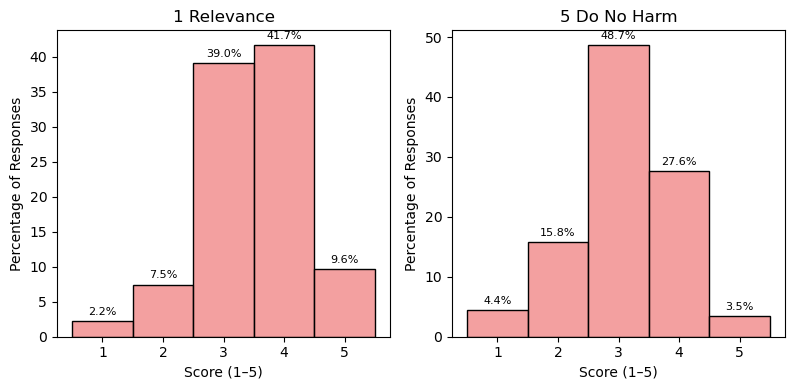

In [34]:
# Histograms of main KPIs
kpis_main = ["1_relevance", "5_do_no_harm"]

plt.figure(figsize=(12,4))

for i, kpi in enumerate(kpis_main):
    plt.subplot(1, 3, i+1)
    sns.histplot(
        data=final_msf,
        x=kpi,
        bins=[1,2,3,4,5,6],
        color='lightcoral',
        stat='percent',
        kde=False
    )
    plt.title(kpi.replace("_", " ").title())
    plt.xlabel("Score (1–5)")
    plt.ylabel("Percentage of Responses")
    # shift ticks to the center of each bar
    plt.xticks([1.5, 2.5, 3.5, 4.5, 5.5], [1, 2, 3, 4, 5])

# add data labels
    ax = plt.gca()
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

#### ❓ What is the spread of responses for each of the KPIs? by country

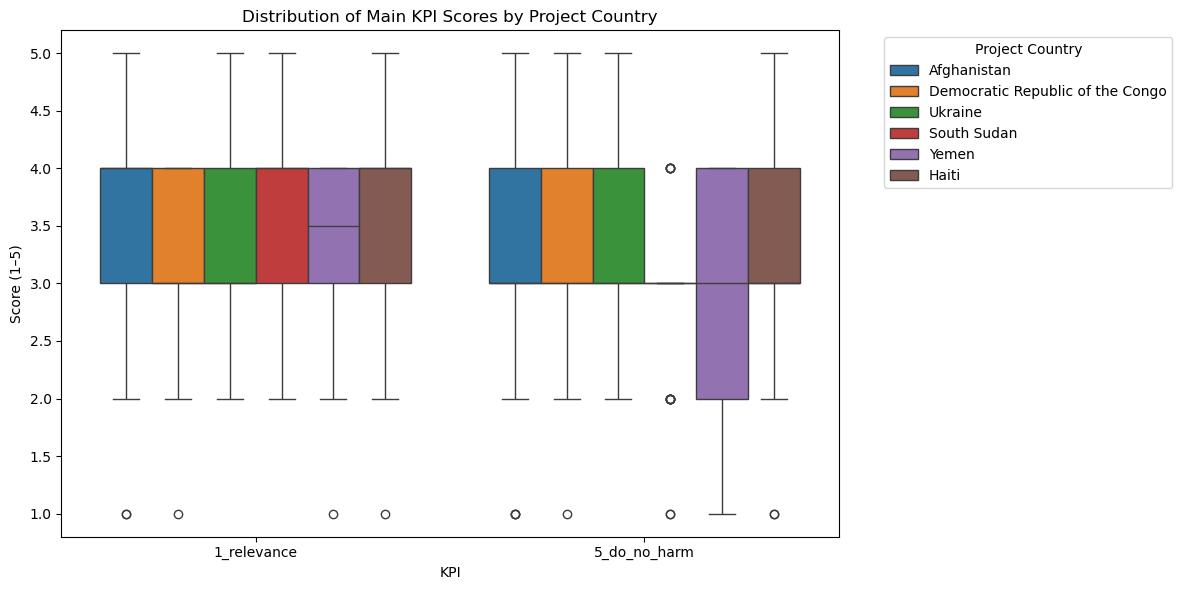

Spread of Q1: Relevance: 
 
 1_relevance                              1          2          3          4  \
project_country                                                               
Afghanistan                       4.347826   6.521739  36.956522  32.608696   
Democratic Republic of the Congo  2.857143  14.285714  34.285714  48.571429   
Haiti                             2.325581   9.302326  34.883721  41.860465   
South Sudan                       0.000000   7.894737  34.210526  42.105263   
Ukraine                           0.000000   2.777778  52.777778  38.888889   
Yemen                             3.333333   3.333333  43.333333  50.000000   

1_relevance                               5  
project_country                              
Afghanistan                       19.565217  
Democratic Republic of the Congo   0.000000  
Haiti                             11.627907  
South Sudan                       15.789474  
Ukraine                            5.555556  
Yemen           

In [35]:
# Box plot for main KPIs by country
long_df = final_msf.melt(
    id_vars=['project_country'],
    value_vars=kpis_main,      # e.g. ["1_relevance", "5_do_no_harm"]
    var_name='KPI',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=long_df,
    x='KPI',
    y='Score',
    hue='project_country'
)

plt.title('Distribution of Main KPI Scores by Project Country')
plt.xlabel('KPI')
plt.ylabel('Score (1–5)')
plt.legend(title='Project Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print quantitative spread of figures
print('Spread of Q1: Relevance:', '\n', '\n', 
      question_spread(final_msf, 'project_country', '1_relevance'), '\n', '\n')
print('Spread of Q3: Do No Harm:', '\n', '\n', 
      question_spread(final_msf, 'project_country', '5_do_no_harm'), '\n', '\n')

#### ❓ What was the median score in each project?

1_relevance     Float64
5_do_no_harm    Float64
dtype: object


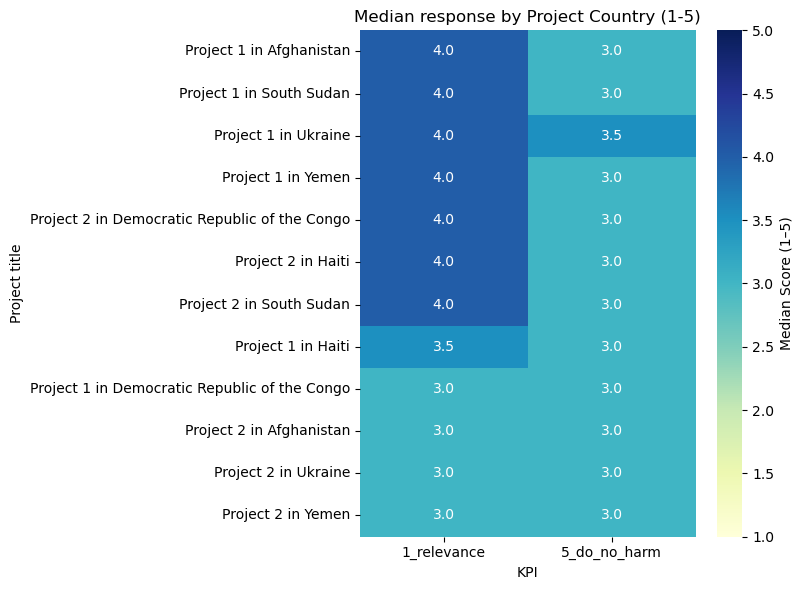

Spread of Q1: Relevance: 
 
 1_relevance                                           1          2          3  \
title_projects                                                                  
Project 1 in Afghanistan                       4.347826   4.347826  34.782609   
Project 1 in Democratic Republic of the Congo  4.545455  13.636364  36.363636   
Project 1 in Haiti                             0.000000  10.000000  40.000000   
Project 1 in South Sudan                       0.000000   6.250000  31.250000   
Project 1 in Ukraine                           0.000000   5.555556  38.888889   
Project 1 in Yemen                             5.882353   0.000000  35.294118   
Project 2 in Afghanistan                       4.347826   8.695652  39.130435   
Project 2 in Democratic Republic of the Congo  0.000000  15.384615  30.769231   
Project 2 in Haiti                             4.347826   8.695652  30.434783   
Project 2 in South Sudan                       0.000000   9.090909  36.363636   

In [36]:
# Make sure KPI columns are numeric
kpi_columns = ['1_relevance', '5_do_no_harm']

final_msf[kpi_columns] = final_msf[kpi_columns].apply(
    pd.to_numeric, errors='coerce'
)

# Build median table
median_heatmap_data = (
    final_msf
    .pivot_table(
        index='title_projects',
        values=kpi_columns,
        aggfunc='median'
    )
)

# Sort by relevance scores
median_heatmap_data = median_heatmap_data.sort_values('1_relevance', ascending=False)

print(median_heatmap_data.dtypes)  # should now show float64 for all KPI columns

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    median_heatmap_data.astype(float),  # ensure numeric
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    vmin=1, vmax=5,
    cbar_kws={'label': 'Median Score (1–5)'}
)
plt.title('Median response by Project Country (1-5)')
plt.xlabel('KPI')
plt.ylabel('Project title')
plt.tight_layout()
plt.show()

# Print quantitative spread of figures
print('Spread of Q1: Relevance:', '\n', '\n', 
      question_spread(final_msf, 'title_projects', '1_relevance'), '\n', '\n')
print('Spread of Q3: Do No Harm:', '\n', '\n', 
      question_spread(final_msf, 'title_projects', '5_do_no_harm'), '\n', '\n')

#### ❓ What was the median response by staff position?

1_relevance     Float64
5_do_no_harm    Float64
dtype: object


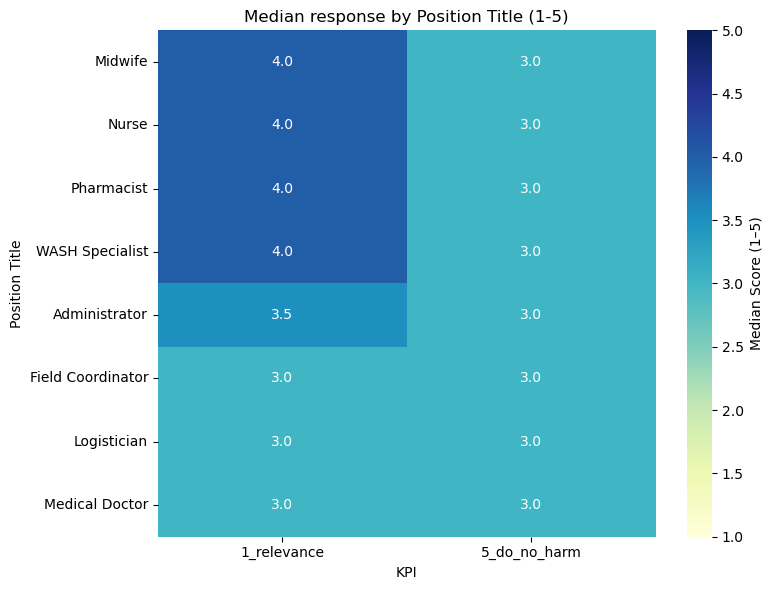

Spread of Q1: Relevance: 
 
 1_relevance               1          2          3          4          5
position_title                                                         
Administrator      0.000000   4.166667  45.833333  41.666667   8.333333
Field Coordinator  2.439024  14.634146  36.585366  31.707317  14.634146
Logistician        0.000000   8.695652  56.521739  17.391304  17.391304
Medical Doctor     3.571429   7.142857  42.857143  42.857143   3.571429
Midwife            4.166667   4.166667  29.166667  54.166667   8.333333
Nurse              2.564103   2.564103  38.461538  51.282051   5.128205
Pharmacist         3.703704   3.703704  40.740741  40.740741  11.111111
WASH Specialist    0.000000  13.636364  22.727273  54.545455   9.090909 
 

Spread of Q3: Do No Harm: 
 
 5_do_no_harm              1          2          3          4         5
position_title                                                        
Administrator      4.166667  12.500000  45.833333  29.166667  8.333333
Fiel

In [37]:
# Make sure KPI columns are numeric
kpi_columns = ['1_relevance', '5_do_no_harm']

final_msf[kpi_columns] = final_msf[kpi_columns].apply(
    pd.to_numeric, errors='coerce'
)

# Build median table
median_heatmap_data = (
    final_msf
    .pivot_table(
        index='position_title',
        values=kpi_columns,
        aggfunc='median'
    )
)

# (optional) sort by relevance for nicer ordering
median_heatmap_data = median_heatmap_data.sort_values('1_relevance', ascending=False)

print(median_heatmap_data.dtypes)  # should now show float64 for all KPI columns

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    median_heatmap_data.astype(float),  # ensure numeric
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    vmin=1, vmax=5,
    cbar_kws={'label': 'Median Score (1–5)'}
)
plt.title('Median response by Position Title (1-5)')
plt.xlabel('KPI')
plt.ylabel('Position Title')
plt.tight_layout()
plt.show()

# Print quantitative spread of figures
print('Spread of Q1: Relevance:', '\n', '\n', 
      question_spread(final_msf, 'position_title', '1_relevance'), '\n', '\n')
print('Spread of Q3: Do No Harm:', '\n', '\n', 
      question_spread(final_msf, 'position_title', '5_do_no_harm'), '\n', '\n')

### ✅ **Key takeaways and insights**

- Central clustering: Both Relevance and Do No Harm show a clear central tendency, with most responses falling between 3 (“moderate”) and 4 (“large extent”). Extreme scores (1 or 5) are relatively rare, indicating overall moderate to high performance and low polarization.

- Differences in skew: Relevance is slightly right-skewed (leaning positive), while Do No Harm is more left-skewed, suggesting that projects are generally perceived as more relevant than risk-mitigating.

- Cross-country variation: Scores for both Relevance and Do No Harm cluster around the mid-to-high range (mostly 3–4), with some variation between countries. Variation in country performance typically happens at the more extreme scores, e.g. Ukraine having no 1/5 scores across both questions, whereas Yemen having no 5/5 scores across both questions.

- By project: Median heatmaps show that most projects hover around 3–4 for Relevance and 3 for Do No Harm, with only a few (e.g. Project 1 in Yemen, Project 1 in Ukraine) edging above 3.5–4. There are a high number of projects that don't have extreme scores (i.e. either 1 or 5). In particular, for DNH the 1/5 scores are driven by a small number of project (e.g. P2 in Yemen).

- By staff position: Heatmaps reveal that field-facing roles (midwives, nurses, WASH specialists) tend to rate projects slightly higher on Relevance (median = 4), while administrative and coordination roles give more conservative scores (median = 3–3.5). Do No Harm scores remain consistently moderate (median = 3) across all positions. Looking at the spread of responses across professions, there is a strong clustering around central measures (e.g. 3/5 representing 45-60% of responses across all professions for DNH). There is some positive skewing (i.e. higher proportion of 4-5/5) responses for non-field facing roles for relevance, e.g. field coordinator and logistician. 

➡️ **What to explore next?**
- Whether performance has changed between 2024 and 2025
- Deep dive into the poor performers - explore which countries and projects consistently perform poorly

## **Section 4️⃣: Answering key questions using data**
In this section we explore specific questions pertaining to MSF's performance against its impact and outcomes KPIs.

### ❓ **Question 1: How successful is MSF in meeting local population needs and mitigating risks?**

### ✅ **Answer 1**

Relevance: 
- Median scores for relevance went down from 4 to 3 between 2024 and 2025.
- In 2024, 54% of respondants believed that MSF projects were mostly or completely meeting the most critical needs of the local population - this went down to 48% in 2025.
- However, looking at the spread across scores, there are a lower proportion of projects scoring 1/5. We see that there is greater clustering around middle scores (2-4) in 2025 than 2024.

Do no harm: 
- Median scores remained consistent at 3 (moderate). Both these values are below MSF's target value of 4. 
- In 2024, 31% of respondants believed that MSF mostly or completely identified and mitigated the negative impacts of the project. This slightly increased in 2025.
- Spread of scores is largely the same, with a shift in answers from 2 to 3. 

Together this indicates, that while MSF was doing a good job of meeting local needs in 2024, performance in both indicators is below target in 2025. However, we have also seen a reduction in the lowest scores for relevance showing an improvement for the worst performing projects.

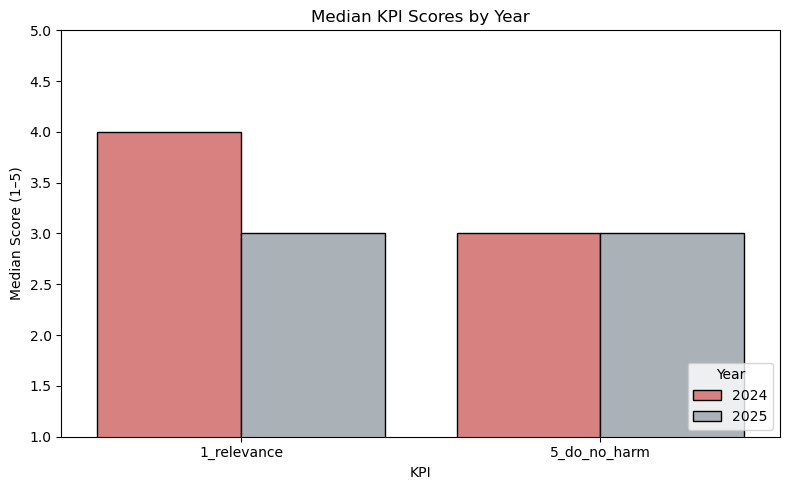

In [38]:
# Calculate median KPI scores by year
kpi_yearly = (
    final_msf
    .groupby('assignment_year')[['1_relevance', '5_do_no_harm']]
    .median()
    .reset_index())

# Plot bar chart
plt.figure(figsize=(8, 5))

sns.barplot(
    data=kpi_yearly.melt(
        id_vars='assignment_year',
        var_name='KPI',
        value_name='Median Score'),
    x='KPI',
    y='Median Score',
    hue='assignment_year',
    palette=['#e57373', "#a8b1b9"],
    edgecolor='black')

plt.title('Median KPI Scores by Year')
plt.xlabel('KPI')
plt.ylabel('Median Score (1–5)')
plt.ylim(1, 5)
plt.legend(title='Year', loc='lower right')
plt.tight_layout()
plt.show()

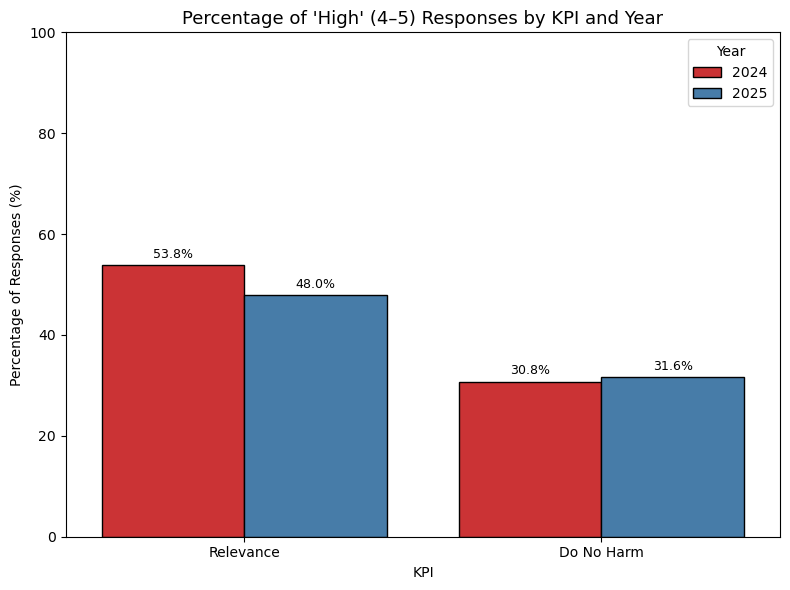

In [39]:
# % of respondents giving "high" scores (4–5) by year

# Define KPIs
kpis = {'1_relevance': 'Relevance',
        '5_do_no_harm': 'Do No Harm'}

# Create high score binary column
for col in kpis.keys():
    final_msf[f'high_{col}'] = final_msf[col].isin([4, 5])

# Calculate yearly % of high responses for each KPI
high_percent_by_year = (
    final_msf
    .dropna(subset=['assignment_year'])
    .groupby('assignment_year')[[f'high_{col}' for col in kpis.keys()]]
    .mean() * 100
)
high_percent_by_year.columns = [kpis[col] for col in kpis.keys()]

# Reshape for easier plotting
high_percent_melted = high_percent_by_year.reset_index().melt(
    id_vars='assignment_year',
    var_name='KPI',
    value_name='Percentage'
)

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(
    data=high_percent_melted,
    x='KPI',
    y='Percentage',
    hue='assignment_year',
    palette='Set1',
    edgecolor='black')

plt.title("Percentage of 'High' (4–5) Responses by KPI and Year", fontsize=13)
plt.xlabel("KPI")
plt.ylabel("Percentage of Responses (%)")
plt.ylim(0, 100)
plt.legend(title='Year')

# Add percentage labels
for c in plt.gca().containers:
    plt.bar_label(c, fmt="%.1f%%", fontsize=9, padding=3)

plt.tight_layout()
plt.show()

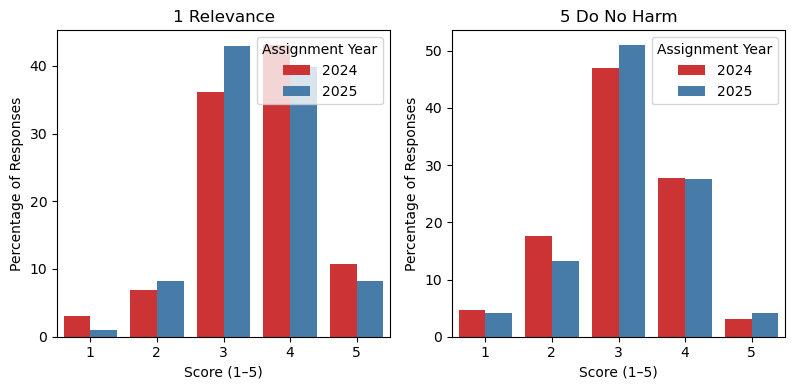

Spread of Q1: Relevance: 
 
 1_relevance             1         2          3          4          5
assignment_year                                                     
2024             3.076923  6.923077  36.153846  43.076923  10.769231
2025             1.020408  8.163265  42.857143  39.795918   8.163265 
 

Spread of Q3: Do No Harm: 
 
 5_do_no_harm            1          2          3          4         5
assignment_year                                                     
2024             4.615385  17.692308  46.923077  27.692308  3.076923
2025             4.081633  13.265306  51.020408  27.551020  4.081633 
 



In [40]:
# Plot spread of responses by year 
# Main KPIs to plot
kpis_main = ["1_relevance", "5_do_no_harm"]

plt.figure(figsize=(12, 4))

for i, kpi in enumerate(kpis_main):
    plt.subplot(1, 3, i + 1)

    # Prepare data for bar chart: calculate percentage by score and year
    data_plot = (
        final_msf
        .groupby(['assignment_year', kpi])
        .size()
        .reset_index(name='count')
    )

    # Convert counts to percentages within each year
    data_plot['percent'] = (
        data_plot.groupby('assignment_year')['count']
        .apply(lambda x: 100 * x / x.sum())
        .reset_index(drop=True)
    )

    # Create grouped bar chart
    sns.barplot(
        data=data_plot,
        x=kpi,
        y='percent',
        hue='assignment_year',
        palette='Set1'
    )

    plt.title(kpi.replace("_", " ").title())
    plt.xlabel("Score (1–5)")
    plt.ylabel("Percentage of Responses")
    plt.legend(title="Assignment Year", loc='upper right')

plt.tight_layout()
plt.show()

# Print quantitative spread of figures
print('Spread of Q1: Relevance:', '\n', '\n', 
      question_spread(final_msf, 'assignment_year', '1_relevance'), '\n', '\n')
print('Spread of Q3: Do No Harm:', '\n', '\n', 
      question_spread(final_msf, 'assignment_year', '5_do_no_harm'), '\n', '\n')

### ❓ **Question 2: Which countries have successfully met local needs and mitigated risks?**

### ✅ **Answer 2**

Relevance: 
- In 2024, DRC, Haiti & Ukraine were on target but have seen a massive drop in proportion of 4-5/5 scores in 2025.
- In 2025, South Sudan and Afghanistan improved performance and were on target. There has been a 'switching' of scores between 3 and 4 for each year.
- Looking at spread, multiple countries have reduced or eliminated their lowest scores (1-2) incl. Afghanistan, South Sudan, Ukraine and Yemen. DRC is the only country with increased lower scores.
- Afghanistan and South Sudan are the only countries that have increased their proportion of 5/5 scores, with all other countries seeing a reduction (or similar proportions). 

Do no harm: 
- All countries other than Afghanistan were below target - Afghanistan scored 4 in 2025.
- Afghanistan, Yemen and South Sudan have all seen improvements from 2024 to 2025 in terms of % of high scores (4-5/5). 
- South Sudan and Afghanistan have reduced or eliminated their lowest scores (1-2/5), however DRC's have increased.

When we look at % of respondants that chose 4 or 5, we see stark improvements in relevance for South Sudan and in do no harm for Afghanistan and Yemen. This indicates that South Sudan has got better at delivering projects that meet local needs and Afghanistan/Yemen has got better at mitigating risks. Based on this, it would be safe to say that Afghanistan and Yemen have performed well on both KPIs in 2025.

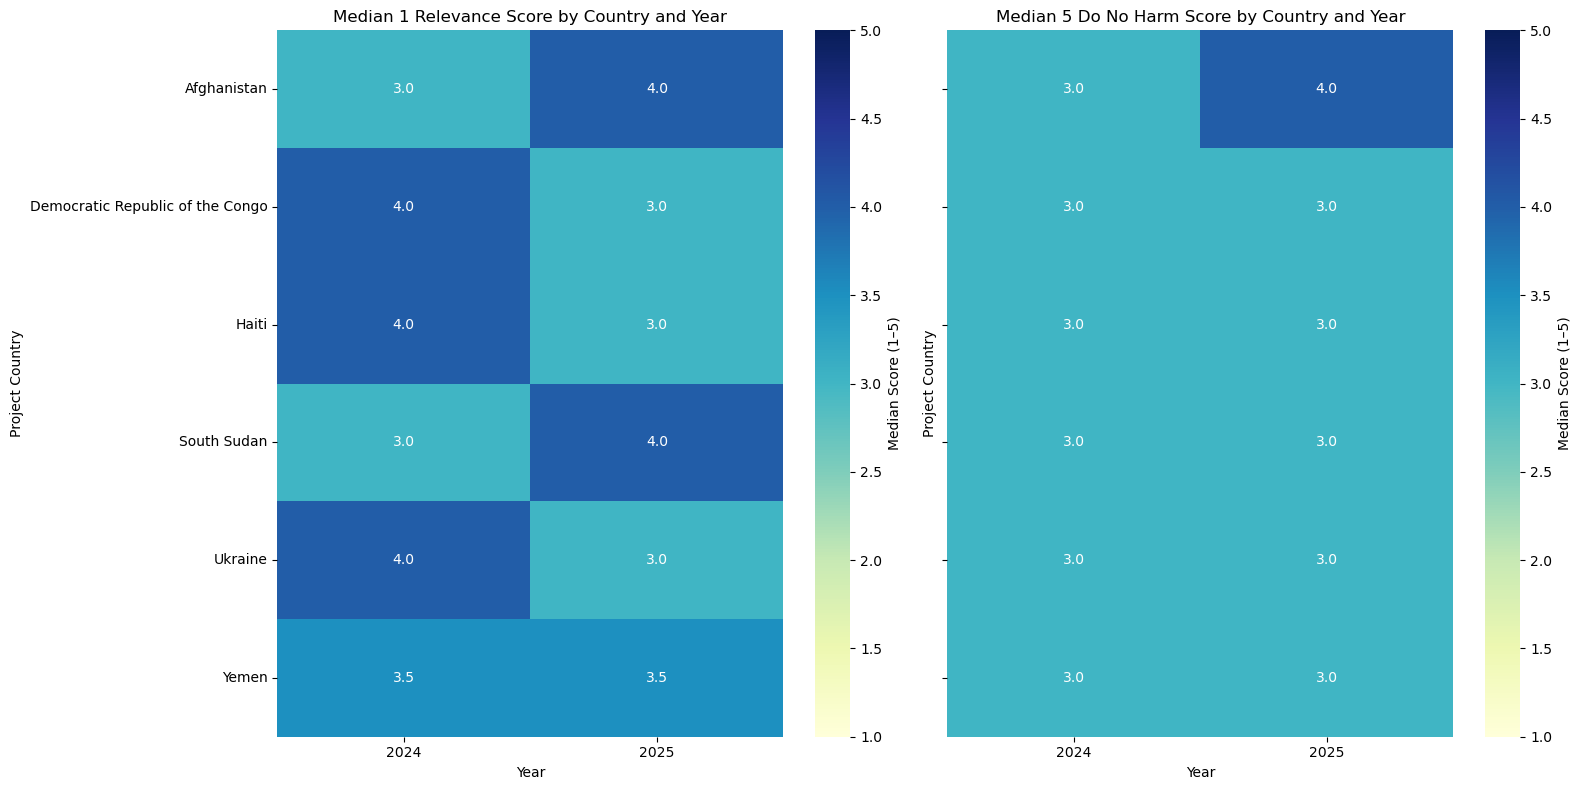

In [41]:
# Heatmap of median scores by country and year

# Calculate median by country and year
median_by_country_year = (
    final_msf
    .groupby(['project_country', 'assignment_year'])[['1_relevance', '5_do_no_harm']]
    .median()
    .reset_index()
    .melt(
        id_vars=['project_country', 'assignment_year'],
        var_name='KPI',
        value_name='Median Score'))

# Plot separate heatmaps per KPI 
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for ax, kpi in zip(axes, median_by_country_year['KPI'].unique()):
    data = (
        median_by_country_year
        .query("KPI == @kpi")
        .pivot_table(
            index='project_country',
            columns='assignment_year',
            values='Median Score'
        )
        .astype(float)
    )

    sns.heatmap(
        data,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        vmin=1, vmax=5,
        cbar_kws={'label': 'Median Score (1–5)'},
        ax=ax
    )

    ax.set_title(f'Median {kpi.replace("_", " ").title()} Score by Country and Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Project Country')

plt.tight_layout()
plt.show()

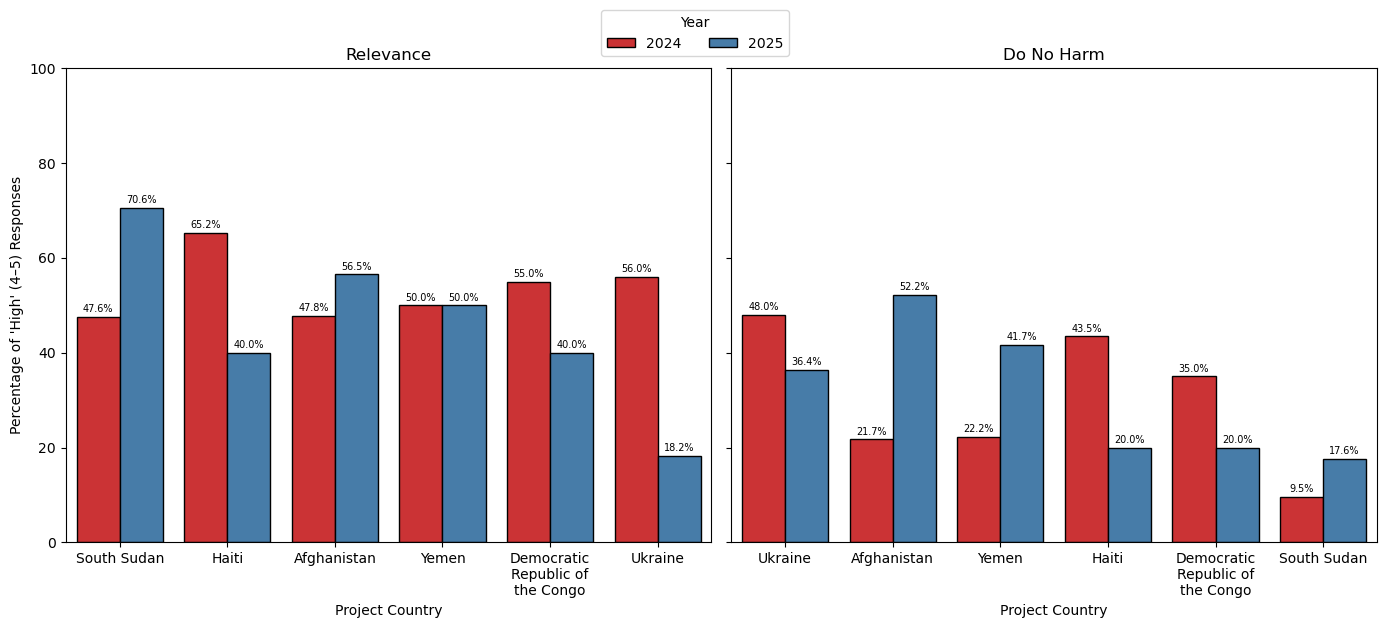

In [42]:
# Plot % of respondents choosing 4 or 5 by country and KPI

# Calculate % of high scores (4–5) by project country and year
high_percent_by_country_year = (
    final_msf
    .dropna(subset=['assignment_year', 'project_country'])
    .groupby(['project_country', 'assignment_year'])[[f'high_{col}' for col in kpis.keys()]]
    .mean()
    * 100)

# Rename columns for readability
high_percent_by_country_year.columns = [kpis[col] for col in kpis.keys()]

# Reshape for plotting
high_percent_melted = (
    high_percent_by_country_year
    .reset_index()
    .melt(
        id_vars=['project_country', 'assignment_year'],
        var_name='KPI',
        value_name='Percentage'))

# Plot each KPI separately
kpi_list = high_percent_melted['KPI'].dropna().unique()

fig, axes = plt.subplots(1, len(kpi_list), figsize=(14, 6), sharey=True)

for ax, kpi in zip(axes, kpi_list):
    data_kpi = high_percent_melted.query("KPI == @kpi").dropna(subset=['Percentage'])

    # Sort countries by average performance
    country_order = (
        data_kpi.groupby('project_country')['Percentage']
        .mean()
        .sort_values(ascending=False)
        .index
    )

    sns.barplot(
        data=data_kpi,
        x='project_country',
        y='Percentage',
        hue='assignment_year',
        palette='Set1',
        edgecolor='black',
        ax=ax,
        order=country_order
    )

    ax.set_title(f"{kpi}", fontsize=12)
    ax.set_xlabel("Project Country")
    ax.set_ylabel("Percentage of 'High' (4–5) Responses")
    ax.set_ylim(0, 100)

    ax.tick_params(axis='x', rotation=0)
    labels = [textwrap.fill(label.get_text(), 12) for label in ax.get_xticklabels()]
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center')

    # Add percentage labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", fontsize=7, padding=2)

    ax.legend_.remove()

# Shared legend at the top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Year", loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

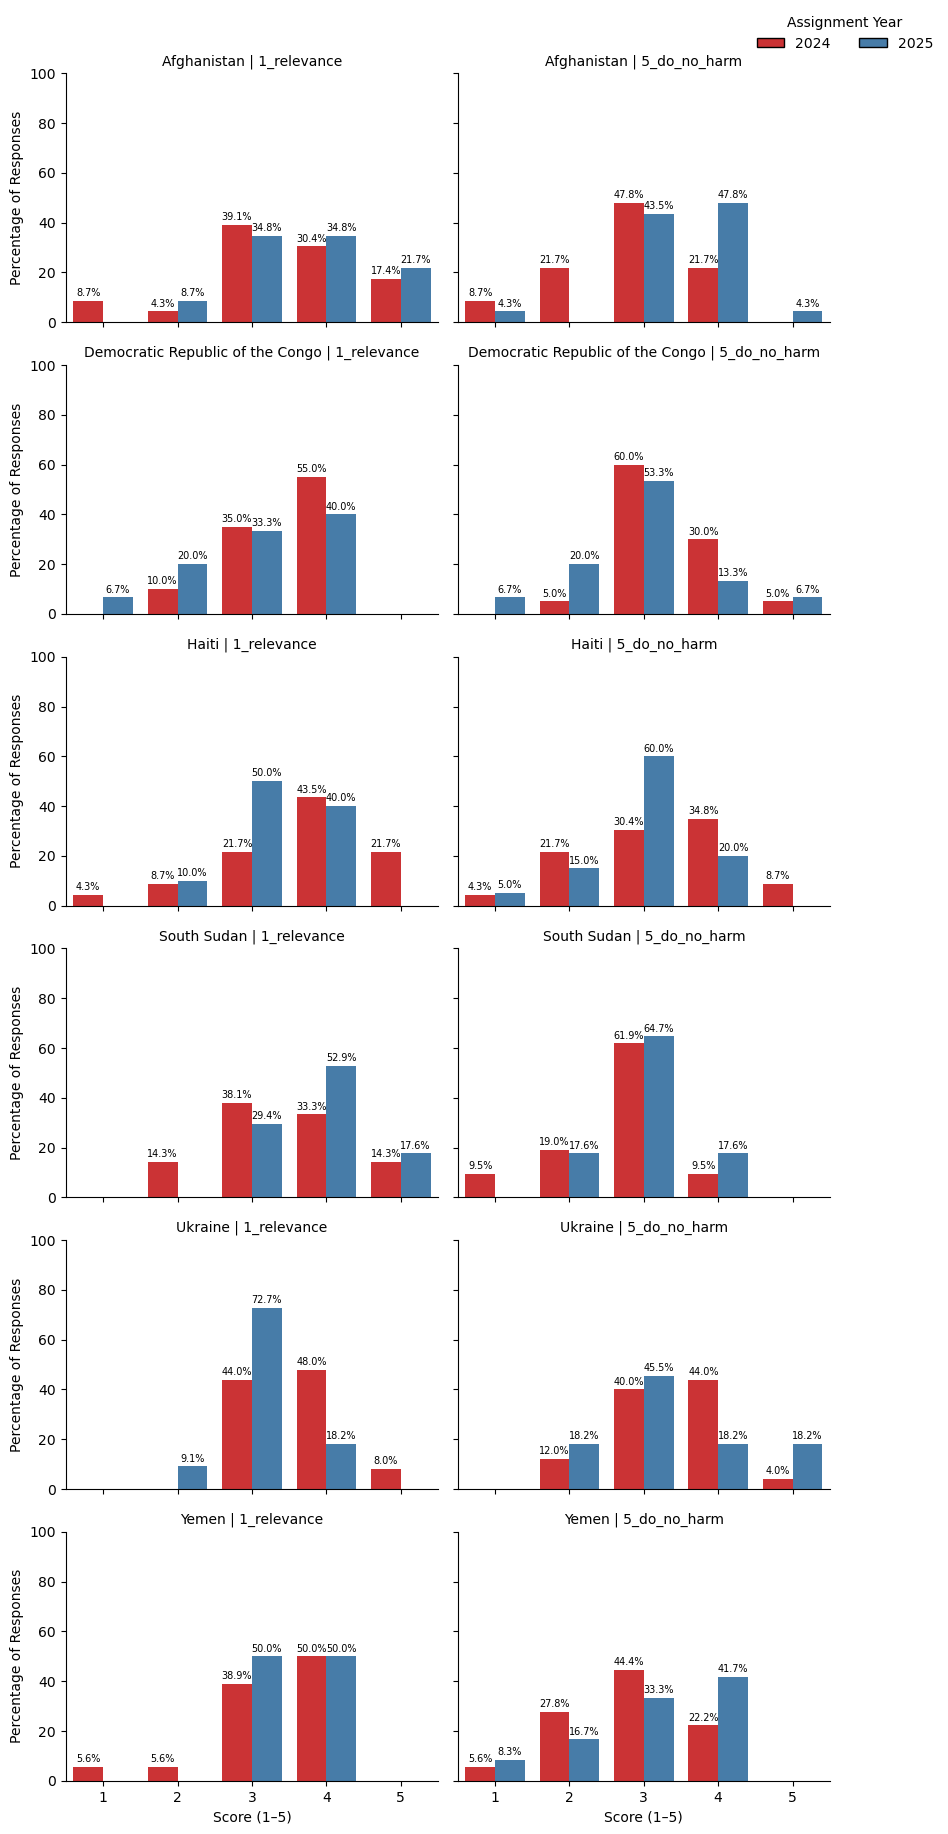

In [43]:
# Plot spread of KPIs (x axis) per country (y axis) per year (hue)

# KPIs to plot
kpis_main = ["1_relevance", "5_do_no_harm"]

# Reshape dataframe so all KPIs are in one column
df_long = final_msf.melt(
    id_vars=['project_country', 'assignment_year'],
    value_vars=kpis_main,
    var_name='KPI',
    value_name='Score')

# Calculate percentage of each score per country per KPI per year
data_plot = (
    df_long
    .groupby(['project_country', 'assignment_year', 'KPI', 'Score'])
    .size()
    .reset_index(name='count'))

# Convert to percentages within each (country, year, KPI) group
data_plot['percent'] = (
    data_plot.groupby(['project_country', 'assignment_year', 'KPI'])['count']
    .apply(lambda x: 100 * x / x.sum())
    .reset_index(drop=True))

# Create faceted bar chart:
g = sns.catplot(
    data=data_plot,
    x='Score',
    y='percent',
    hue='assignment_year',
    col='KPI',
    row='project_country',
    kind='bar',
    height=3,
    aspect=1.2,
    palette='Set1')

# Formatting
g.set_axis_labels("Score (1–5)", "Percentage of Responses")
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set(ylim=(0, 100))

# Remove default legend and move to top
g._legend.remove()
g.fig.legend(
    handles=handles,
    labels=labels,
    title="Assignment Year",
    loc='upper center',
    ncol=len(labels) if len(labels) > 0 else 1,
    frameon=False,
    bbox_to_anchor=(1, 1.02))

# Tidy up x-axis labels and add bar annotations
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
    # Add labels above bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom',
                        fontsize=7, color='black',
                        xytext=(0, 2), textcoords='offset points')

plt.tight_layout()
plt.show()

### ❓ **Question 3: Why have Afghanistan, Yemen and South Sudan done well for relevance, and Afghanistan and Ukraine for DNH?**

### ✅ **Answer 3**

Relevance: 
- Projects 1 in South Sudan, Yemen & Afghanistan contributed to the countries' on target performance for relevance - all with 56%+ of 4-5/5 scores.
- In all countries, feedback mechanisms, regular check-ins and community dialogues contributed to the good performance.

Do no harm: 
- Both projects 1 and 2 in Afghanistan and Ukraine score relatively highly (noting that for all countries, DNH scores are lower than relevance scores).
- In Ukraine, the driving factor was psycho-support and for Afghanistan it was regulary check-ins.

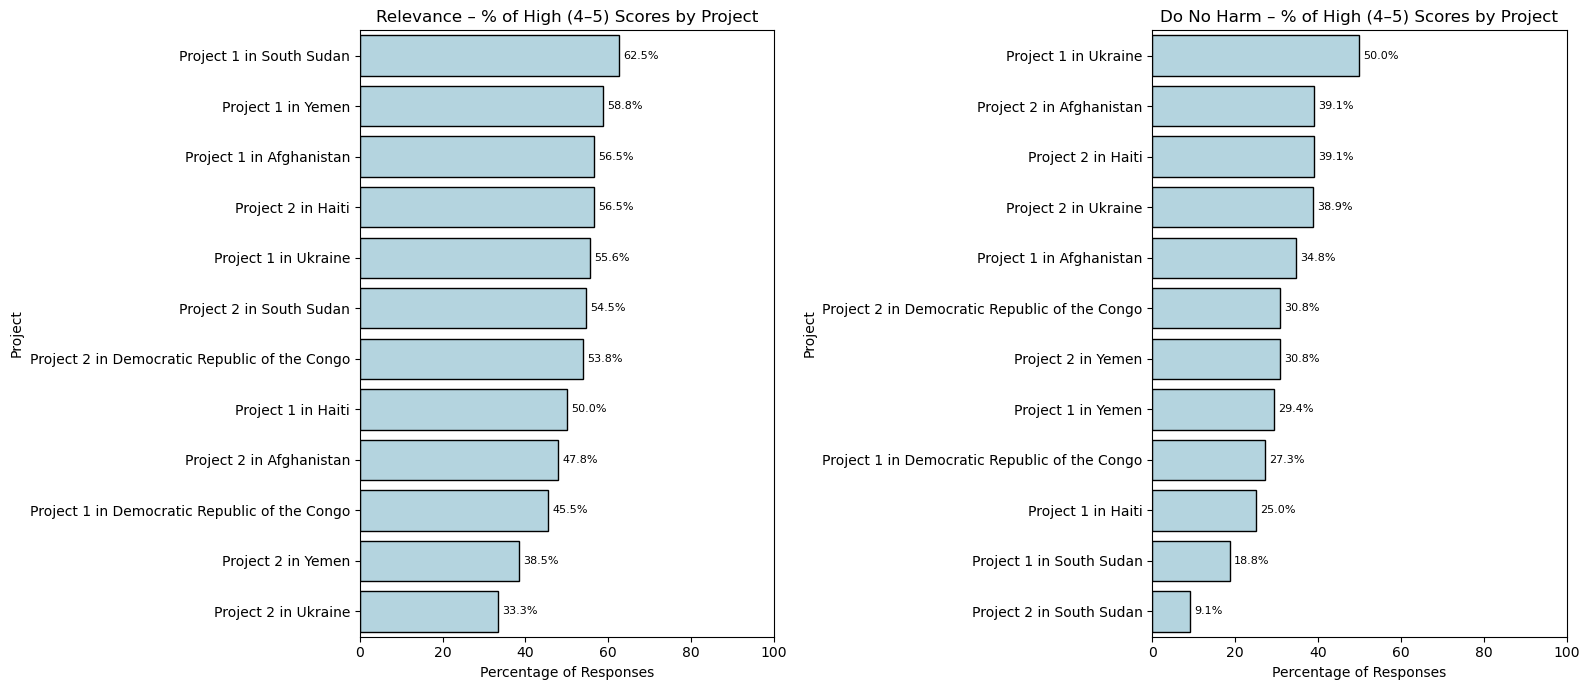

In [44]:
# project breakdown of % high scores (4–5) for main KPIs to see which projects in Afg and SS are doing well

# Create nicer label for KPIs
kpis = {
    '1_relevance': 'Relevance',
    '5_do_no_harm': 'Do No Harm'
}

# Plot bar graph
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (col_raw, col_label) in zip(axes, kpis.items()):

    data = (
        final_msf
        .dropna(subset=['title_projects', col_raw])
        .groupby('title_projects')[col_raw]
        # Create percentage of responses that are 4-5/5
        .agg(lambda x: (x >= 4).mean() * 100)
        .reset_index(name=col_label)
        .sort_values(col_label, ascending=False))

    sns.barplot(
        data=data,
        y='title_projects',
        x=col_label,
        color='LightBlue',
        edgecolor='black',
        ax=ax)

    ax.set_title(f"{col_label} – % of High (4–5) Scores by Project")
    ax.set_xlabel("Percentage of Responses")
    ax.set_ylabel("Project")
    ax.set_xlim(0, 100)


    # Add % labels
    for i, v in enumerate(data[col_label]):
        ax.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [45]:
# spread of qualitative responses for relevance for South Sudan to see how population demands were integrated 

# Filter for South Sudan
ss_relevance = final_msf[final_msf['project_country'] == 'South Sudan']

# Set to display full question length and print
print("How effectively were population demands integrated into the project strategy in South Sudan?")
with pd.option_context('display.max_colwidth', None):
    display(group_total_percent(ss_relevance, '2_relevance'))

How effectively were population demands integrated into the project strategy in South Sudan?


,2_relevance,count,percentage
0,Feedback mechanisms improved complaint handling.,13,37.142857
1,Community dialogues reduced misinformation and refusals.,12,34.285714
2,Women’s groups informed clinic scheduling.,10,28.571429


In [46]:
# spread of qualitative responses for relevance for Afghanistan to see how population demands were integrated 

# Filter for Afghanistan
afg_relevance = final_msf[final_msf['project_country'] == 'Afghanistan']

# Set to display full question length and print
print("How effectively were population demands integrated into the project strategy in Afghanistan?")
with pd.option_context('display.max_colwidth', None):
    display(group_total_percent(afg_relevance, '2_relevance'))

How effectively were population demands integrated into the project strategy in Afghanistan?


,2_relevance,count,percentage
0,Feedback mechanisms improved complaint handling.,15,34.883721
1,Community dialogues reduced misinformation and refusals.,14,32.558140
2,Women’s groups informed clinic scheduling.,14,32.558140


In [47]:
# spread of qualitative responses for relevance for Yemen to see how population demands were integrated 

# Filter for Yemen
yem_relevance = final_msf[final_msf['project_country'] == 'Yemen']

# Set to display full question length and print
print("How effectively were population demands integrated into the project strategy in Yemen?")
with pd.option_context('display.max_colwidth', None):
    display(group_total_percent(yem_relevance, '2_relevance'))

How effectively were population demands integrated into the project strategy in Yemen?


,2_relevance,count,percentage
0,Women’s groups informed clinic scheduling.,11,37.931034
1,Community dialogues reduced misinformation and refusals.,9,31.034483
2,Feedback mechanisms improved complaint handling.,9,31.034483


In [48]:
# spread of qualitative responses for do no harm for Afghanistan to see how risks were mitigated

# Filter for Afghanistan
afg_dnh = final_msf[final_msf['project_country'] == 'Afghanistan']

# Set to display full question length and print
print("How effectively were risks monitored and managed throughout the project in Afghanistan?")
with pd.option_context('display.max_colwidth', None):
    display(group_total_percent(afg_dnh, '6_do_no_harm'))

How effectively were risks monitored and managed throughout the project in Afghanistan?


,6_do_no_harm,count,percentage
0,Regular check-ins helped during surge weeks.,20,48.780488
1,Psycho-social support existed but was hard to schedule.,11,26.829268
2,Accommodation improved after early feedback cycles.,10,24.390244


In [49]:
# spread of qualitative responses for do no harm for Ukraine to see how risks were mitigated

# Filter for Ukraine
ukr_dnh = final_msf[final_msf['project_country'] == 'Ukraine']

# Set to display full question length and print
print("How effectively were risks monitored and managed throughout the project in Ukraine?")
with pd.option_context('display.max_colwidth', None):
    display(group_total_percent(ukr_dnh, '6_do_no_harm'))

How effectively were risks monitored and managed throughout the project in Ukraine?


,6_do_no_harm,count,percentage
0,Psycho-social support existed but was hard to schedule.,16,45.714286
1,Accommodation improved after early feedback cycles.,10,28.571429
2,Regular check-ins helped during surge weeks.,9,25.714286


### ❓ **Question 4: Which countries & projects are performing poorly?**

### ✅ **Answer 4**
- DRC (for relevance) and Yemen (for do no harm) have the highest % of respondants giving negative feedback (choosing 1 or 2).
- Yemen is an interesting case: it provides a lot of relevance for the population but there are unresolved issues of DNH. This perhaps is due to the difficult country context of Yemen.

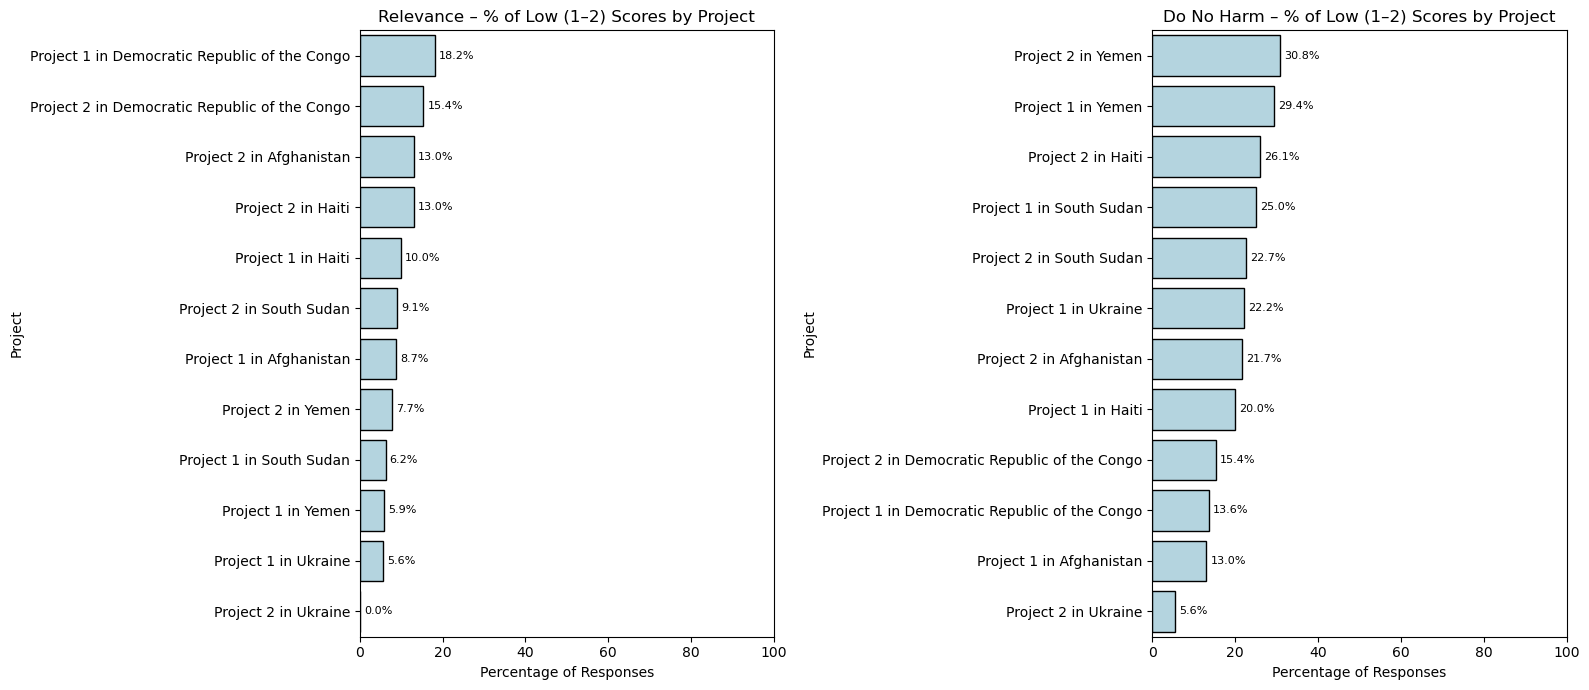

In [50]:
# Create nicer label for KPIs
kpis = {
    '1_relevance': 'Relevance',
    '5_do_no_harm': 'Do No Harm'}

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (col_raw, col_label) in zip(axes, kpis.items()):
    # % low (1–2) scores by project for THIS KPI only
    data = (
        final_msf
        .dropna(subset=['title_projects', col_raw])
        .groupby('title_projects')[col_raw]
        .agg(lambda x: (x <= 2).mean() * 100)
        .reset_index(name=col_label)
        .sort_values(col_label, ascending=False))

    sns.barplot(
        data=data,
        y='title_projects',
        x=col_label,
        color='lightblue',
        edgecolor='black',
        ax=ax)

    ax.set_title(f"{col_label} – % of Low (1–2) Scores by Project")
    ax.set_xlabel("Percentage of Responses")
    ax.set_ylabel("Project")
    ax.set_xlim(0, 100)


    # Add % labels
    for i, v in enumerate(data[col_label]):
        ax.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()

## **Section 5️⃣: Advanced analysis: Do certain KPIs contribute to improved outcomes for local populations?**

⚠️ For this analysis, we are using relevance (the extent to which local needs are met) and DNHas our Y-variable (dependent) because it is the closest proxy for assessing impact on local populations. We will conduct the same analysis using three methods and will compare results.
1. OLS (incl. MLR)
2. Logistic Regression
3. Decision trees

### 5.1 OLS Analysis of the Relationship between Relevance and other KPIs (where likert score is treated as continuous)

**✅ Key Takeaways**

- The regression model explains less than 8% of the variation (R^2 = 7.7) in how respondents rated project relevance — a weak but statistically significant relationship.
- “Do No Harm” is the strongest and only significant positive predictor of relevance (β = 0.20, p = 0.003).
- “Staff is Supported and Cared For” and “Population Centeredness” show weak negative trends with relevance (p ≈ 0.06–0.07), but these are not statistically significant.
- Other KPIs, including effectiveness, coherence with MSF values, resource use, and agility, do not show meaningful associations with relevance.
- Multicollinearity is minimal (VIF ≈ 1), confirming that these KPIs measure distinct aspects of project performance.

**➡️ Next Steps**

- Because relevance is measured on a 1–5 Likert scale, we will test the same through an ordinal logistic regression in the next step to more appropriately model it as an ordered categorical variable rather than a continuous one, to check if we get more accurate and statistically valid results.

In [51]:
# Check the correlation between numerical question responses
corr_cols = final_msf[['1_relevance',
                       '3_effectiveness',
                       '5_do_no_harm',
                       '7_integrated_in_environment',
                       '9_coherent_with_msf_values', 
                       '11_population_centeredness', 
                       '13_staff_is_supported_and_cared_for', 
                       '17_resources_are_used_responsibly',
                       '21_agile_and_clear_decisions']]

corr_cols.corr()

,1_relevance,3_effectiveness,5_do_no_harm,7_integrated_in_environment,9_coherent_with_msf_values,11_population_centeredness,13_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,21_agile_and_clear_decisions
1_relevance,1.000000,0.072701,0.178046,0.034212,-0.023779,-0.114197,-0.100733,0.013589,0.077666
3_effectiveness,0.072701,1.000000,0.048974,0.034881,0.065618,0.052867,0.067684,0.004410,-0.090124
5_do_no_harm,0.178046,0.048974,1.000000,-0.011111,0.087957,0.096778,0.109170,0.088191,0.014630
7_integrated_in_environment,0.034212,0.034881,-0.011111,1.000000,0.128549,-0.036086,0.085597,0.036939,0.089536
9_coherent_with_msf_values,-0.023779,0.065618,0.087957,0.128549,1.000000,0.060696,0.099079,0.114380,0.159733
11_population_centeredness,-0.114197,0.052867,0.096778,-0.036086,0.060696,1.000000,0.075653,0.037120,-0.078911
13_staff_is_supported_and_cared_for,-0.100733,0.067684,0.109170,0.085597,0.099079,0.075653,1.000000,0.066438,0.061829
17_resources_are_used_responsibly,0.013589,0.004410,0.088191,0.036939,0.114380,0.037120,0.066438,1.000000,-0.043323
21_agile_and_clear_decisions,0.077666,-0.090124,0.014630,0.089536,0.159733,-0.078911,0.061829,-0.043323,1.000000


In [52]:
# Prepare data for regression analysis
cols = ["1_relevance",
        "3_effectiveness",
        "5_do_no_harm",
        "7_integrated_in_environment",
        "9_coherent_with_msf_values",
        "11_population_centeredness",
        "13_staff_is_supported_and_cared_for",
        "17_resources_are_used_responsibly",
        "21_agile_and_clear_decisions"]

# Convert to numeric; anything non-numeric becomes NaN
for c in cols:
    final_msf[c] = pd.to_numeric(final_msf[c], errors="coerce")

# Drop rows where any of these are missing
final_msf_regression = final_msf[cols].dropna()

print(final_msf_regression.dtypes)
final_msf_regression.head()

1_relevance                            Int64
3_effectiveness                        Int64
5_do_no_harm                           Int64
7_integrated_in_environment            Int64
9_coherent_with_msf_values             Int64
11_population_centeredness             Int64
13_staff_is_supported_and_cared_for    Int64
17_resources_are_used_responsibly      Int64
21_agile_and_clear_decisions           Int64
dtype: object


,1_relevance,3_effectiveness,5_do_no_harm,7_integrated_in_environment,9_coherent_with_msf_values,11_population_centeredness,13_staff_is_supported_and_cared_for,17_resources_are_used_responsibly,21_agile_and_clear_decisions
0,3,2,1,5,4,3,2,3,4
1,4,3,4,4,4,2,2,4,3
2,3,4,2,3,5,4,4,4,4
3,4,4,4,3,3,3,3,4,4
4,4,3,2,4,1,3,3,2,1


In [53]:
# Singular linear regression, analysing each KPI's relationship with relevance individually 

# Define outcome and predictors
outcome = "1_relevance"
predictors = ["3_effectiveness", 
              "5_do_no_harm",
              "7_integrated_in_environment",
              "9_coherent_with_msf_values",
              "11_population_centeredness",
              "13_staff_is_supported_and_cared_for",
              "17_resources_are_used_responsibly",
              "21_agile_and_clear_decisions"]

# Run regression
results_simple = []

for kpi in predictors:
    X = final_msf_regression[[kpi]].astype(float)
    X = sm.add_constant(X)
    y = final_msf_regression[outcome].astype(float)

    model = sm.OLS(y, X).fit()
    
    results_simple.append({
        "KPI": kpi,
        "Coefficient": model.params[kpi],
        "P-value": model.pvalues[kpi],
        "R-squared": model.rsquared})

simple_summary = pd.DataFrame(results_simple).sort_values("R-squared", ascending=False)

print("\nSimple regressions (each KPI vs relevance): \n")
simple_summary


Simple regressions (each KPI vs relevance): 



,KPI,Coefficient,P-value,R-squared
1,5_do_no_harm,0.175799,0.007215,0.031643
4,11_population_centeredness,-0.113917,0.086039,0.013041
5,13_staff_is_supported_and_cared_for,-0.101270,0.130238,0.010147
7,21_agile_and_clear_decisions,0.074643,0.243835,0.006032
0,3_effectiveness,0.067532,0.274384,0.005307
2,7_integrated_in_environment,0.030999,0.608119,0.001170
3,9_coherent_with_msf_values,-0.020371,0.721585,0.000565
6,17_resources_are_used_responsibly,0.011968,0.838649,0.000185


In [54]:
# Multi-linear regression with all KPIs

# Set x and y variables
X = final_msf_regression[predictors].astype(float)
X = sm.add_constant(X)
y = final_msf_regression[outcome].astype(float)

# Create model
model = sm.OLS(y, X).fit()

# Standardized regression (for comparing importance)
scaler = StandardScaler()
df_std = pd.DataFrame(
    scaler.fit_transform(final_msf_regression[[outcome] + predictors]),
    columns=[outcome] + predictors)

y_std = df_std[outcome]
X_std = sm.add_constant(df_std[predictors])

model_std = sm.OLS(y_std, X_std).fit()

beta_table = (
    model_std.params.drop("const")
    .to_frame("Standardized Beta")
    .assign(p_value=model_std.pvalues.drop("const"))
    .assign(abs_beta=lambda d: d["Standardized Beta"].abs())
    .sort_values("abs_beta", ascending=False))

# Print model
print("\nMultiple regression summary:")
print(model.summary())
print("\n Standardized regression coefficients: \n")
beta_table


Multiple regression summary:
                            OLS Regression Results                            
Dep. Variable:            1_relevance   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.286
Date:                Fri, 07 Nov 2025   Prob (F-statistic):             0.0227
Time:                        15:30:19   Log-Likelihood:                -276.57
No. Observations:                 227   AIC:                             571.1
Df Residuals:                     218   BIC:                             602.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

,Standardized Beta,p_value,abs_beta
5_do_no_harm,0.200623,0.002708,0.200623
13_staff_is_supported_and_cared_for,-0.124425,0.061947,0.124425
11_population_centeredness,-0.118348,0.074189,0.118348
3_effectiveness,0.087214,0.186473,0.087214
21_agile_and_clear_decisions,0.085938,0.200343,0.085938
9_coherent_with_msf_values,-0.048036,0.477289,0.048036
7_integrated_in_environment,0.037668,0.569188,0.037668
17_resources_are_used_responsibly,0.015997,0.808559,0.015997


In [55]:
# VIF (multicollinearity check)
X_vif = final_msf_regression[predictors].astype(float).assign(const=1)
vif_data = [
    {"Variable": col, "VIF": variance_inflation_factor(X_vif.values, i)}
    for i, col in enumerate(X_vif.columns)]

vif_df = pd.DataFrame(vif_data)

print("\n Variance Inflation Factors: \n")
vif_df


 Variance Inflation Factors: 



,Variable,VIF
0,3_effectiveness,1.023334
1,5_do_no_harm,1.033350
2,7_integrated_in_environment,1.031515
3,9_coherent_with_msf_values,1.075841
4,11_population_centeredness,1.028243
5,13_staff_is_supported_and_cared_for,1.039090
6,17_resources_are_used_responsibly,1.027608
7,21_agile_and_clear_decisions,1.057735
8,const,81.883120


### 5.2 Logistic Regression Analysis of the Relationship between Impact KPIs and other KPIs (where likert score is treated as ordered categorical data)

**✅ Key Takeaways**

Relevance: 
- The ordinal logistic regression confirms that overall project relevance is most strongly and positively associated with the KPI “Do No Harm.” Projects rated higher on this dimension are significantly more likely to receive higher relevance scores. Based on the log odds, a 1 point increase in DNH scores has a 55.5% chance of increasing the relevance scores.
- Staff is supported KPI is also significant (at the 5%). Interestingly, it shows a negative relationship, i.e. an increase in staff support scores by 1 point has a 25% chance of decreasing relevance scores. 
- Other KPIs — including effectiveness, population centeredness, etc. do not show statistically significant effects, suggesting that perceptions of relevance are relatively independent of these operational factors.

Do No Harm: 
- As expected, the biggest predictor of DNH is the relevance KPI (as we see dual causality between the two KPIs). Based on the log odds, a 1 point increase in relevance scores has a 60% chance of increasing the DNH scores.
- The only other statistically significant metric (at the 1% level) is that staff are supported and cared for. Based on the log odds, a 1 point increase in staff support scores has a 31% chance of increasing the DNH scores. 

**➡️ Next Steps**

- Repeat analysis but for an aggregated impact score vs. just the process KPIs. This will also help to better understand how to increase impact from project inception, need to determine how to improve the process KPIs - rather than based on other outcome KPIs (DNH and effectiveness) which happen after the fact. It will also better show where the thresholds are for these indicators. 

In [56]:
# Define outcome and predictors
outcome = "1_relevance"
predictors = ["3_effectiveness",
              "5_do_no_harm",
              "7_integrated_in_environment",
              "9_coherent_with_msf_values",
              "11_population_centeredness",
              "13_staff_is_supported_and_cared_for",
              "17_resources_are_used_responsibly",
              "21_agile_and_clear_decisions"]

# Set x and y variables
y = final_msf_regression[outcome].astype(int)
X = final_msf_regression[predictors].astype(float)

# Fit ordinal logistic regression
ordinal_model = OrderedModel(y, X, distr="logit")
ordinal_result = ordinal_model.fit(method="bfgs")

# Extract coefficients and standard errors for predictors
coefs = ordinal_result.params[predictors]
std_err = ordinal_result.bse[predictors]

# Calculate odds ratio and % change in odds
odds_table = pd.DataFrame({
    'feature': coefs.index,
    'coefficient': coefs.values,
    'std_err': std_err.values})

# Compute odds ratio and % change in odds
odds_table['odds_ratio'] = np.exp(odds_table['coefficient'])
odds_table['%_change_in_odds'] = (odds_table['odds_ratio'] - 1) * 100

# Print model 
print("\n Logistic Regression Model Results: \n")
print(ordinal_result.summary())
print("\n Odds Table: \n")
odds_table

Optimization terminated successfully.
         Current function value: 1.199179
         Iterations: 29
         Function evaluations: 30
         Gradient evaluations: 30

 Logistic Regression Model Results: 

                             OrderedModel Results                             
Dep. Variable:            1_relevance   Log-Likelihood:                -272.21
Model:                   OrderedModel   AIC:                             568.4
Method:            Maximum Likelihood   BIC:                             609.5
Date:                Fri, 07 Nov 2025                                         
Time:                        15:30:19                                         
No. Observations:                 227                                         
Df Residuals:                     215                                         
Df Model:                           8                                         
                                          coef    std err          z      P>|z

,feature,coefficient,std_err,odds_ratio,%_change_in_odds
0,3_effectiveness,0.175580,0.138302,1.191938,19.193754
1,5_do_no_harm,0.441944,0.151746,1.555729,55.572922
2,7_integrated_in_environment,0.070419,0.133273,1.072957,7.295723
3,9_coherent_with_msf_values,-0.100994,0.129755,0.903938,-9.606159
4,11_population_centeredness,-0.247043,0.151885,0.781107,-21.889256
5,13_staff_is_supported_and_cared_for,-0.299119,0.148180,0.741471,-25.852879
6,17_resources_are_used_responsibly,0.049009,0.133579,1.050229,5.022944
7,21_agile_and_clear_decisions,0.153791,0.147450,1.166248,16.624768


In [57]:
# Define outcome and predictors
outcome = "5_do_no_harm"
predictors = ["1_relevance",
              "3_effectiveness",
              "7_integrated_in_environment",
              "9_coherent_with_msf_values",
              "11_population_centeredness",
              "13_staff_is_supported_and_cared_for",
              "17_resources_are_used_responsibly",
              "21_agile_and_clear_decisions"]

# Set x and y variables
y = final_msf_regression[outcome].astype(int)
X = final_msf_regression[predictors].astype(float)

# Fit ordinal logistic regression
ordinal_model = OrderedModel(y, X, distr="logit")
ordinal_result = ordinal_model.fit(method="bfgs")

# Extract coefficients and standard errors for predictors
coefs = ordinal_result.params[predictors]
std_err = ordinal_result.bse[predictors]

# Calculate odds ratio and % change in odds
odds_table = pd.DataFrame({
    'feature': coefs.index,
    'coefficient': coefs.values,
    'std_err': std_err.values})

# Compute odds ratio and % change in odds
odds_table['odds_ratio'] = np.exp(odds_table['coefficient'])
odds_table['%_change_in_odds'] = (odds_table['odds_ratio'] - 1) * 100

# Print model 
print("\n Logistic Regression Model Results: \n")
print(ordinal_result.summary())
print("\n Odds Table: \n")
odds_table

Optimization terminated successfully.
         Current function value: 1.215108
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30

 Logistic Regression Model Results: 

                             OrderedModel Results                             
Dep. Variable:           5_do_no_harm   Log-Likelihood:                -275.83
Model:                   OrderedModel   AIC:                             575.7
Method:            Maximum Likelihood   BIC:                             616.8
Date:                Fri, 07 Nov 2025                                         
Time:                        15:30:19                                         
No. Observations:                 227                                         
Df Residuals:                     215                                         
Df Model:                           8                                         
                                          coef    std err          z      P>|z

,feature,coefficient,std_err,odds_ratio,%_change_in_odds
0,1_relevance,0.471019,0.154054,1.601626,60.162619
1,3_effectiveness,0.053499,0.135238,1.054956,5.495570
2,7_integrated_in_environment,-0.102225,0.135292,0.902826,-9.717354
3,9_coherent_with_msf_values,0.106123,0.130665,1.111959,11.195854
4,11_population_centeredness,0.209821,0.149966,1.233457,23.345720
5,13_staff_is_supported_and_cared_for,0.271347,0.155230,1.311730,31.172979
6,17_resources_are_used_responsibly,0.196378,0.132122,1.216987,21.698714
7,21_agile_and_clear_decisions,-0.001629,0.145963,0.998372,-0.162751


### 5.3 Logistic Regression Analysis of the Relationship between all impact KPIs and only process KPIs (where grouped total impact score is treated as ordered categorical data)

**✅ Key Takeaways**

- Unlike the above model (which includes other impact KPIs), process KPIs alone don't yield statistically significant results. Therefore, the model in section 5.2 should be used for interpretation and recommendations.

**➡️ Next Steps**
- Investigate these relationships further through decision trees, to allow for non-linear relationships.
- In particular, determine whether this better explains the relationship between staff support and relevance. 

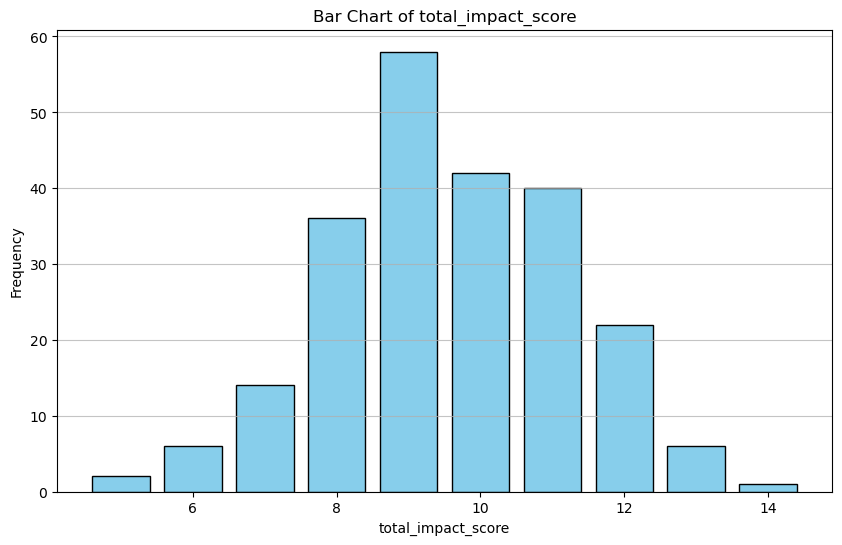

In [58]:
# Create new 'total impact' column and determine distribution 
impact_cols = ["1_relevance", "3_effectiveness", "5_do_no_harm"]
final_msf_regression['total_impact_score'] = final_msf_regression[impact_cols].sum(axis=1)

# Count occurrences of each unique value
counts = final_msf_regression['total_impact_score'].value_counts().sort_index()

# Plot as a bar chart
plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.title('Bar Chart of total_impact_score')
plt.xlabel('total_impact_score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [59]:
# Create new binary column of whether is low impact (score of 8 or below), medium (9-10), or high (11-15).
final_msf_regression["impact_cat"] = final_msf_regression["total_impact_score"].apply(
    lambda x: 1 if 1 <= x <= 8
    else 2 if 9 <= x <= 10 
    else 3 if 11 <= x <= 15 
    else None)

# Check it is sufficiently balanced
group_total_percent(final_msf_regression, 'impact_cat')

,impact_cat,count,percentage
0,2,100,44.052863
1,3,69,30.396476
2,1,58,25.550661


In [60]:
# Define outcome and predictors
outcome = "impact_cat"
predictors = ["7_integrated_in_environment",
              "9_coherent_with_msf_values",
              "11_population_centeredness",
              "13_staff_is_supported_and_cared_for",
              "17_resources_are_used_responsibly",
              "21_agile_and_clear_decisions"]

# Set x and y variables
y = final_msf_regression[outcome].astype(int)
X = final_msf_regression[predictors].astype(float)

# Fit ordinal logistic regression
ordinal_model = OrderedModel(y, X, distr="logit")
ordinal_result = ordinal_model.fit(method="bfgs")

# Extract coefficients and standard errors for predictors
coefs = ordinal_result.params[predictors]
std_err = ordinal_result.bse[predictors]

# Calculate odds ratio and % change in odds
odds_table = pd.DataFrame({
    'feature': coefs.index,
    'coefficient': coefs.values,
    'std_err': std_err.values})

# Compute odds ratio and % change in odds
odds_table['odds_ratio'] = np.exp(odds_table['coefficient'])
odds_table['%_change_in_odds'] = (odds_table['odds_ratio'] - 1) * 100

# Print model 
print("\n Logistic Regression Model Results: \n")
print(ordinal_result.summary())
print("\n Odds Table: \n")
odds_table

Optimization terminated successfully.
         Current function value: 1.059644
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27

 Logistic Regression Model Results: 

                             OrderedModel Results                             
Dep. Variable:             impact_cat   Log-Likelihood:                -240.54
Model:                   OrderedModel   AIC:                             497.1
Method:            Maximum Likelihood   BIC:                             524.5
Date:                Fri, 07 Nov 2025                                         
Time:                        15:30:20                                         
No. Observations:                 227                                         
Df Residuals:                     219                                         
Df Model:                           6                                         
                                          coef    std err          z      P>|z

,feature,coefficient,std_err,odds_ratio,%_change_in_odds
0,7_integrated_in_environment,0.085051,0.133330,1.088772,8.877231
1,9_coherent_with_msf_values,0.125713,0.130606,1.133957,13.395712
2,11_population_centeredness,0.051770,0.150799,1.053134,5.313394
3,13_staff_is_supported_and_cared_for,0.107856,0.147346,1.113887,11.388729
4,17_resources_are_used_responsibly,0.201023,0.132871,1.222653,22.265323
5,21_agile_and_clear_decisions,-0.050562,0.141512,0.950695,-4.930540


### 5.4 Decision Tree Analysis of the Relationship between Impact KPIs and other KPIs 

**✅ Key Takeaways**

Relevance: 
- Model accuracy does not improve after 3 brances, so pruned to avoid overfitting and improve readability.
- As with above models, DNH is the most important predictor of relevance. Agile decision, staff support, coherent with MSF values and integrated into the environment also have predictive power. 
- Model accuracy is relatively low: 57%. This means it's only just better than a random guess (which would have 50% accuracy). Model tends to overpredict that the relevance score will be high (4+). This may be due to imbalanced class sizes, despite rebalancing. 
- Logistic regression model in section 5.2 yields better results.

DNH: 
- Model accuracy does not improve after 3 brances, so pruned to avoid overfitting and improve readability.
- Contrary to above models, the relevance KPI has low importance for defining whether projects have low/high DNH scores. The most important explanatory KPI is coherence with MSF values. Other important KPIs include integrated in environment, agile decisions, staff support and population centeredness.
- Model accuracy is better (68%) showing it has more explanatory power. Model tends to overpredict low relevance (<4). This may be due to imbalanced class sizes, despite rebalancing.
- Model can be used in tandem with logistic regression to understand drivers of DNH scores.

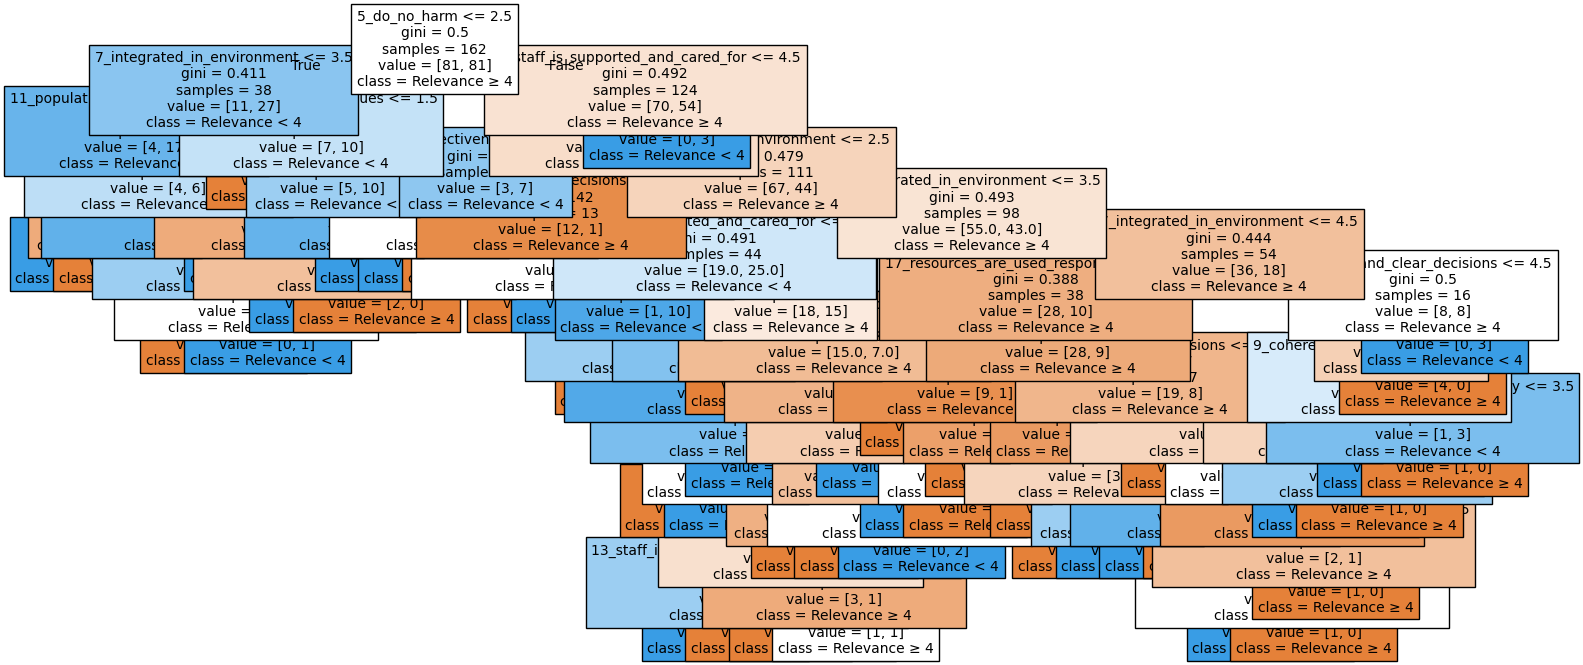

In [61]:
# Create new binary column of whether is low relevance (score of 3 or below)
final_msf_regression["low_relevance"] = (final_msf_regression["1_relevance"] < 4).astype(int)

# Define the X and Y variables
y = final_msf_regression["low_relevance"]
X = final_msf_regression[["3_effectiveness",
                          "5_do_no_harm",
                          "7_integrated_in_environment",
                          "9_coherent_with_msf_values",
                          "11_population_centeredness",
                          "13_staff_is_supported_and_cared_for",
                          "17_resources_are_used_responsibly",
                          "21_agile_and_clear_decisions"]].astype(int)

# Split into test and train (at 30/70 ratio) and apply SMOTE to deal with class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Fit decision tree with no max depth
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_balanced, y_train_balanced)

# Plot tree
plt.figure(figsize=(18, 8))
plot_tree(tree, feature_names=X.columns, class_names=["Relevance ≥ 4", "Relevance < 4"], filled=True, fontsize=10)
plt.show()

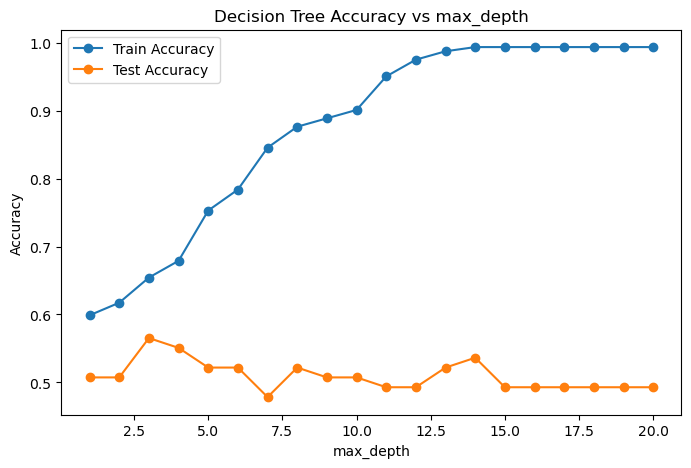

In [62]:
# Determine the optimal value for max depth
train_acc = []
test_acc = []
depths = range(1, 21)  # test depths from 1 to 20

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train_balanced, y_train_balanced)
    train_acc.append(tree.score(X_train_balanced, y_train_balanced))
    test_acc.append(tree.score(X_test, y_test))

# Plot accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(depths, train_acc, label='Train Accuracy', marker='o')
plt.plot(depths, test_acc, label='Test Accuracy', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs max_depth')
plt.legend()
plt.show()

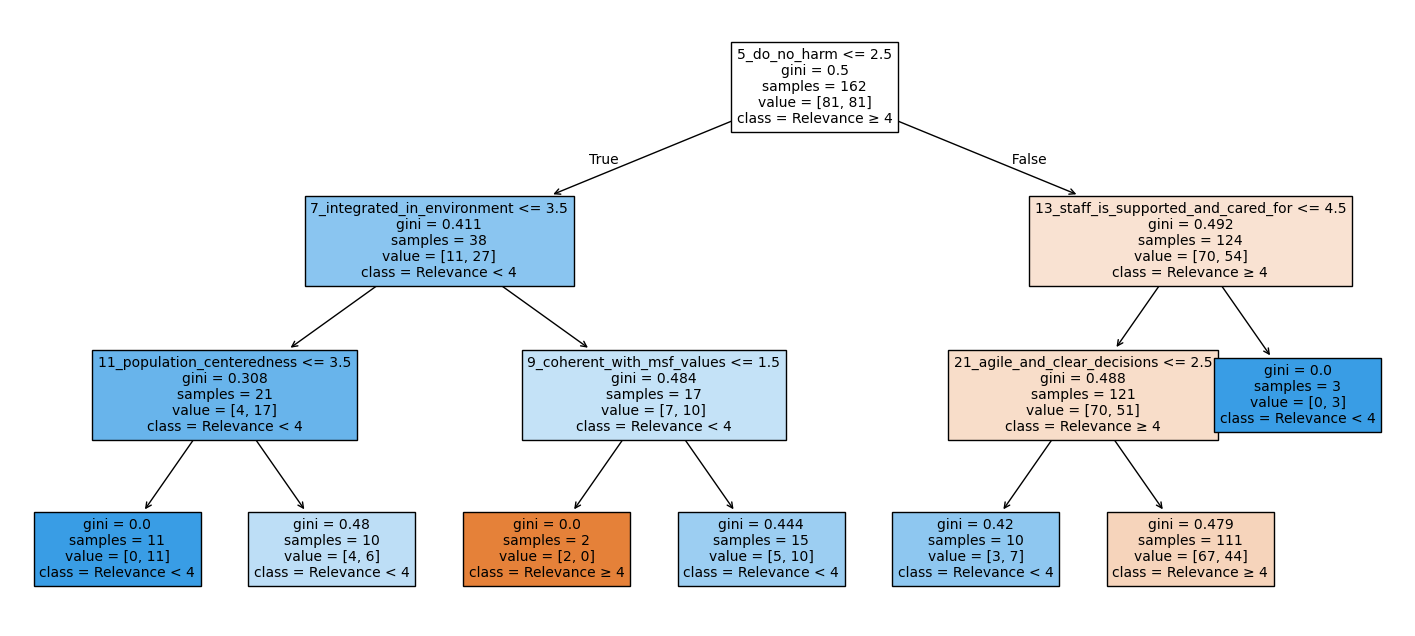

In [63]:
# Re run the tree with 3 levels based on the accuracy analysis 
tree = DecisionTreeClassifier(random_state=42, max_depth=3)
tree.fit(X_train_balanced, y_train_balanced)

# Plot tree
plt.figure(figsize=(18, 8))
plot_tree(tree, feature_names=X.columns, class_names=["Relevance ≥ 4", "Relevance < 4"], filled=True, fontsize=10)
plt.show()

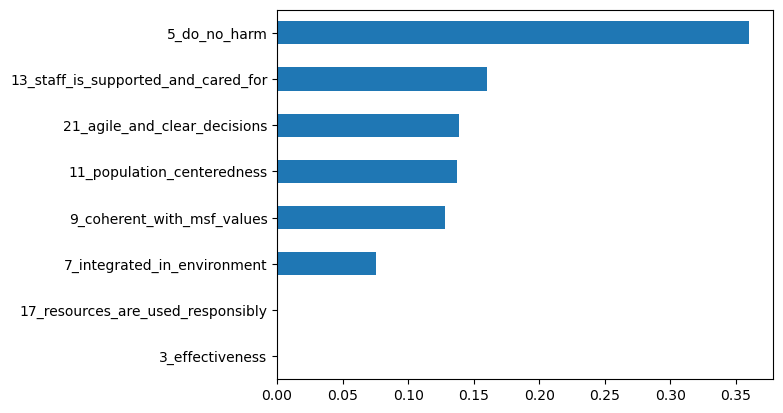

In [64]:
# Visualise the importance of different variables
importances = pd.Series(tree.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh")
plt.show()


 Accuracy score: 0.5652173913043478

 Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.78      0.65        36
           1       0.58      0.33      0.42        33

    accuracy                           0.57        69
   macro avg       0.57      0.56      0.54        69
weighted avg       0.57      0.57      0.54        69



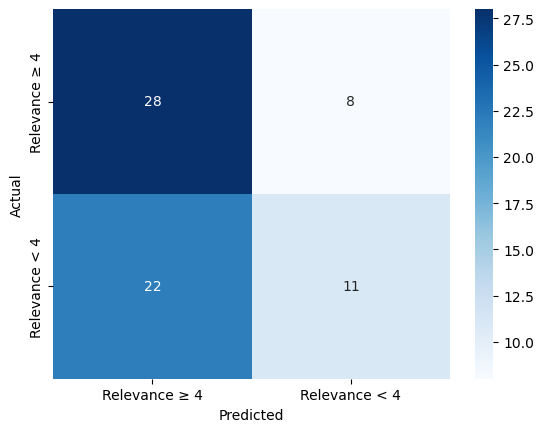

In [65]:
# Evaluate the model

# Print the accuracy score 
y_pred = tree.predict(X_test)
print("\n Accuracy score:",
      accuracy_score(y_test, y_pred))

# Print the classification report
print("\n Classification Report: \n", classification_report(y_test, y_pred))

# Plot the confusion matrix
y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Relevance ≥ 4", "Relevance < 4"],
            yticklabels=["Relevance ≥ 4", "Relevance < 4"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

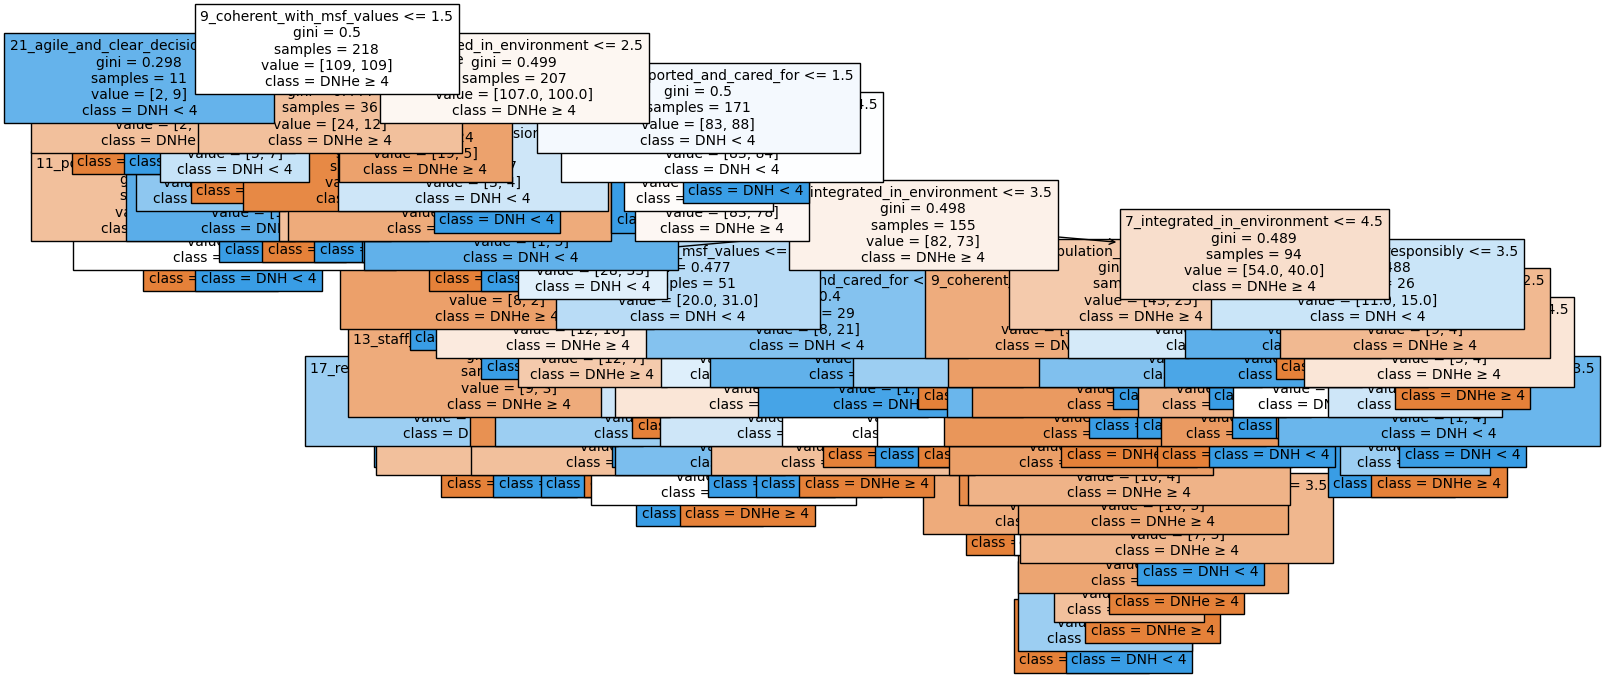

In [66]:
# Repeat analysis for DNH column 

# Create new binary column of whether is low DNH (score of 3 or below)
final_msf_regression["low_dnh"] = (final_msf_regression["5_do_no_harm"] < 4).astype(int)

# Define the X and Y variables
y = final_msf_regression["low_dnh"]
X = final_msf_regression[["1_relevance", 
                          "3_effectiveness",
                          "7_integrated_in_environment",
                          "9_coherent_with_msf_values",
                          "11_population_centeredness",
                          "13_staff_is_supported_and_cared_for",
                          "17_resources_are_used_responsibly",
                          "21_agile_and_clear_decisions"]].astype(int)

# Split into test and train (at 30/70 ratio) and apply SMOTE to deal with class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Fit decision tree with no max depth
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_balanced, y_train_balanced)

# Plot tree
plt.figure(figsize=(18, 8))
plot_tree(tree, feature_names=X.columns, class_names=["DNHe ≥ 4", "DNH < 4"], filled=True, fontsize=10)
plt.show()

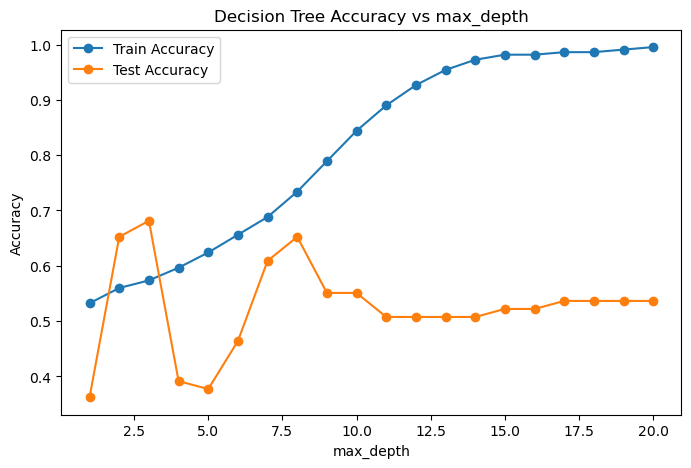

In [67]:
# Determine the optimal value for max depth
train_acc = []
test_acc = []
depths = range(1, 21)  # test depths from 1 to 20

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train_balanced, y_train_balanced)
    train_acc.append(tree.score(X_train_balanced, y_train_balanced))
    test_acc.append(tree.score(X_test, y_test))

# Plot accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(depths, train_acc, label='Train Accuracy', marker='o')
plt.plot(depths, test_acc, label='Test Accuracy', marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs max_depth')
plt.legend()
plt.show()

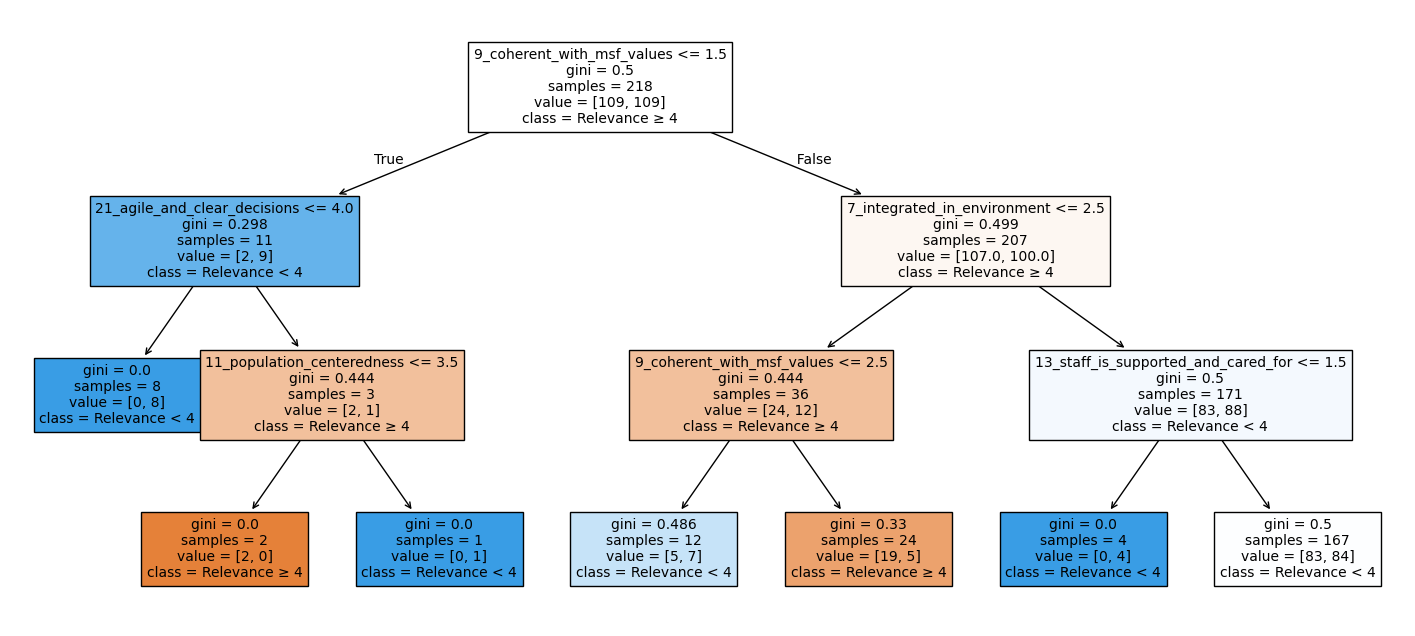

In [68]:
# Re run the tree with 3 levels based on the accuracy analysis 
tree = DecisionTreeClassifier(random_state=42, max_depth=3)
tree.fit(X_train_balanced, y_train_balanced)

# Plot tree
plt.figure(figsize=(18, 8))
plot_tree(tree, feature_names=X.columns, class_names=["Relevance ≥ 4", "Relevance < 4"], filled=True, fontsize=10)
plt.show()

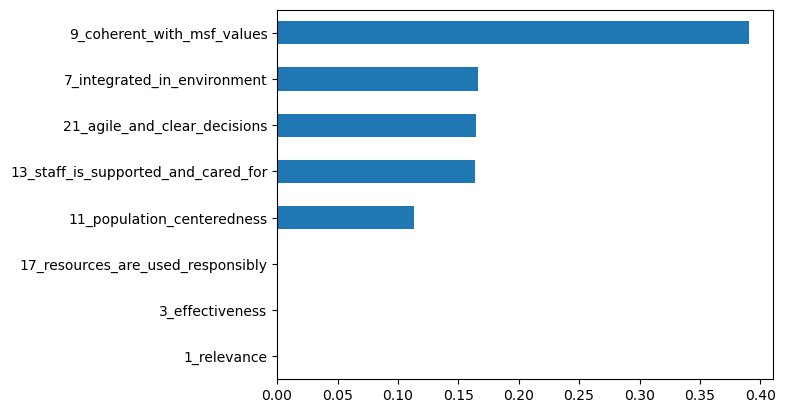

In [69]:
# Visualise the importance of different variables
importances = pd.Series(tree.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh")
plt.show()


 Accuracy score: 0.6811594202898551

 Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.14      0.21        22
           1       0.70      0.94      0.80        47

    accuracy                           0.68        69
   macro avg       0.60      0.54      0.51        69
weighted avg       0.64      0.68      0.61        69



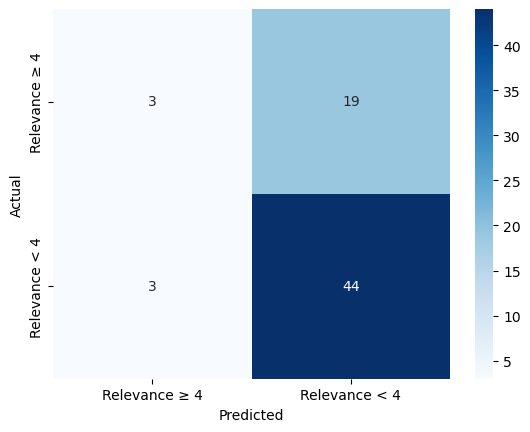

In [70]:
# Evaluate the model

# Print the accuracy score 
y_pred = tree.predict(X_test)
print("\n Accuracy score:",
      accuracy_score(y_test, y_pred))

# Print the classification report
print("\n Classification Report: \n", classification_report(y_test, y_pred))

# Plot the confusion matrix
y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Relevance ≥ 4", "Relevance < 4"],
            yticklabels=["Relevance ≥ 4", "Relevance < 4"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### 5.5 Insight into the best predictors of Relevance and Do No Harm
Here we look at the qualitative responses of the predictors from the above analysis to generate recommended actions and best practices for projects to implement to improve their ability to meet critical needs of local populations and reduce negative impact.

In [72]:
# breakdown of 10_coherent_with_MSF_values
final_msf['10_coherent_with_msf_values'].value_counts(normalize=True) * 100


10_coherent_with_msf_values
Regular check-ins helped during surge weeks.               41.203704
Accommodation improved after early feedback cycles.        31.018519
Psycho-social support existed but was hard to schedule.    27.777778
Name: proportion, dtype: float64

In [73]:
# breakdown of 8_integrated_in_environment
final_msf['8_integrated_in_environment'].value_counts(normalize=True) * 100


8_integrated_in_environment
Local partner coordination reduced duplication.    36.529680
Context analysis informed SOP adaptation.          34.703196
Joint supervisions with MoH improved referrals.    28.767123
Name: proportion, dtype: float64

In [77]:
# breakdown of 14_staff_is_supported_and_cared_for
final_msf['14_staff_is_supported_and_cared_for'].value_counts(normalize=True)*100


14_staff_is_supported_and_cared_for
Regular check-ins helped during surge weeks.               35.023041
Accommodation improved after early feedback cycles.        33.179724
Psycho-social support existed but was hard to schedule.    31.797235
Name: proportion, dtype: float64

In [78]:
# breakdown of 12_population_centeredness
final_msf['12_population_centeredness'].value_counts(normalize=True) * 100


12_population_centeredness
Women’s groups informed clinic scheduling.                  35.023041
Feedback mechanisms improved complaint handling.            33.179724
Community dialogues reduced misinformation and refusals.    31.797235
Name: proportion, dtype: float64

## Section 6️⃣: Summary and Recommendations

#### 📊 **Analytical Summary:**
- This analysis set out to determine whether MSF projects have been 'successful', as defined by the Relevance and Do No Harm KPIs. It explored this through descriptive statistics, breaking down scores by: (1) spread across 1-5/5, (2) % of 'high' (4-5) and 'low' (1-2) scores, (3) median scores. It also broke this down by categories including country and position title of employee.

- It also set out to better understand the drivers of whether MSF projects contribute to improved outcomes for local populations, as defined by the Relevance KPI. It tested different predictive and explanatory models to determine which other KPIs had most explanatory power, including through OLS (and MLR), logistic ordinal regressions and decision trees.

#### ❓ **Findings - Success of MSF Projects:**
- MSF performs better against the relevance KPI than the Do No Harm KPI (holding true for all score breakdowns), i.e. they are more able to deliver improved outcomes for population but are less able to mitigate the negative risks associated with this. This is likely due to the extreme contexts in which MSF operates, namely war zones, areas with high poverty etc.

- There is a large spread across the performance of countries, and this can vary significantly by year. Furthermore, countries which perform well in relevance do not necessarily perform well in Do No Harm. Again, this likely reflects fast changing and differing environments that MSF operate in.

- Across both metrics, qualitative analysis shows that high performing countries and projects tend to have: regular check-ins, feedback cycles, psycho-support and community dialogue. It is clear that good operating systems for staff in the countries is important, with MSF OCB and frontline staff working in coordination. 

#### ❓ **Findings - Drivers of the Relevance KPI:**

- For the Relevance KPI, the most effective predictive model was the ordinal logistic regression (see Section 5.2).

- The analysis found that the main factor influencing Relevance is how well projects perform on the Do No Harm (DNH) KPI.
In other words, projects that proactively identify and reduce potential negative impacts tend to be rated as more relevant to the needs of the population.

- The decision tree analysis highlighted a clear threshold for Do No Harm at 2.5.
Projects with a Do No Harm score of 2 or lower are very likely to also have low Relevance scores (3 or below).

- This suggests that risk management from the start of a project, such as anticipating harm and mitigating it early, plays a key role in ensuring that a project remains relevant and effective.

- As Do No Harm is such a strong predictor of Relevance, it is important to focus on what drives Do No Harm in order to improve overall project performance.

#### ❓ **Findings - Drivers of the DNH KPI:**
- Both statistical and decision-tree models identified several important factors that influence a project’s ability to avoid harm and manage risks effectively.

- **Staff Support:**
    - When staff feel well supported and cared for, projects are more likely to manage risks effectively.
Even a 1-point improvement in staff support increases the likelihood of a better Do No Harm score by about 25%.
Conversely, when staff support scores are very low (1/5), projects are much more likely to perform poorly on Do No Harm.

- **Coherence with MSF Values:**
    - Projects that strongly align with MSF’s principles and values tend to have higher Do No Harm scores.
The analysis found clear risk thresholds — when coherence scores fall to 2 or below, Do No Harm scores drop sharply.

- **Other important determiners of lower Do No Harm**:

    - Agile decisions, integrated in the environment and population centeredness. This suggests that generally, projects which have a better decision-making structure and better context-specific design will be better at identifying and mitigating risks.

#### ➡️ **Recommendations - For MSF:**
- Projects that care for their staff, stay true to MSF values, and adapt quickly to their local context are better at managing potential harm, which in turn makes them more relevant and impactful to the populations they serve. **Case studies** of high-performing projects should explore what made them successful, leading to a set of best practices for improving Do No Harm and Relevance. Supplement this with training on how to best identify and mitigate risks for project managers. 

- Qualitative analysis shows that regular check-ins, feedback cycles, local partnerships, context analysis, joint supervisions with health ministries, women's groups and community dialogue are good practices.

- Projects which fall below key thresholds should be flagged for review. Projects which fail against multiple thresholds should require urgent review, with measures put in place to address issues where possible (noting due to the operating environment of some projects this may not be possible). Further funding should only be provided once proven that issues have been addressed. 

#### ➡️ **Recommendations - Dashboard:**
- Based on the predictive analysis above, the dashboard should identify and flag any projects which fall below the thresholds identified, with greater importance placed on flagging projects which fail against multiple thresholds. This will improve MSF's ability to identify poorly performing projects earlier, then adapt their implementation based on issues. In our Power BI dashboard, we will develop a sample risk tracker to demonstrate this.

#### ➡️ **Recommendations - Technical:**
- The Effectiveness KPI (another impact KPI) was excluded from our analysis because the way it was framed did not capture the extent to which the project met its objectives. The quantitative question for Effectiveness was 'Were the project’s objectives realistic and achievable within the set timeframe?' while the qualitative question was 'Did the project achieve its expected results? Please explain'. We think the quantative question should be reframed to 'On a scale of 1 to 5, how effectively did the project meet its stated objectives?' to accurately capture impact on local population. 

- Using median vs. mean score - MSF currently uses mean score as a measure for its KPIs. We used the median instead of the mean because the data are ordinal Likert-scale responses, where the median better represents the central tendency without being skewed by extreme values. MSF should consider reshaping its survey or its KPI calculation. It can either remove the Likert-scale in the questions and allow respondants to freely score between 1-5. Or it should change its KPI calculation to median. 

- The predictive analysis will be most effective both at the start of the project (when designing the project and learning from 'best practice' of previous high performing projects) and during the implementation of projects. Adding in a mid-point survey as well as the final survey would allow MSF to better flag live projects which do not meet key thresholds before they are fully implemented, and therefore adapt the project to improve performance. 

- For all metrics, there is significant 'clustering' around 3/5. While we would expect a normal distribution across the scale (1-5), it is likely that 3/5 is favoured as it is the 'middle of the road' score that is easiest for people to allocate. Recommend to make the scoring clearer and provide additional guidance on what each score truly means, as well as messaging to staff that providing high/low scores allows for better understanding of why projects have gone well and won't necessarily mean more/less funding is allocated.

- To note, there is significant year-on-year fluctuations in the performance of projects, likely due to rapidly changing environments that MSF work in. Therefore, once more data is collected, suggest looking at overall trends rather than specific year-on-year changes. 